## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import libraries

In [ ]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
%matplotlib inline

## Function to calibrate the camera

In [ ]:
def calibrateCamera(imgpath, nx, ny, calibrationfile):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(imgpath)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
            dist_pickle = {}
            dist_pickle["objpoints"] = objpoints
            dist_pickle["imgpoints"] = imgpoints
            pickle.dump(dist_pickle, open(calibrationfile, "wb"))

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
# Example code
calibrateCamera('camera_cal/calibration*.jpg', 9, 6, "wide_dist_pickle.p")

## Undistort image function

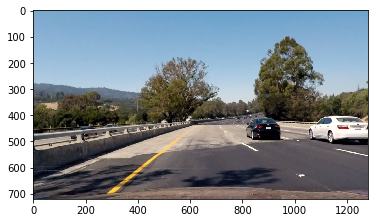

In [2]:
def undistortImage(img, calibrationfile):
    if(os.path.isfile(calibrationfile)):
        # Read in the saved objpoints and imgpoints
        dist_pickle = pickle.load(open(calibrationfile, "rb"))
        objpoints = dist_pickle["objpoints"]
        imgpoints = dist_pickle["imgpoints"]

        # Do camera calibration given object points and image points
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

        # Undistort the image
        undist = cv2.undistort(img, mtx, dist, None, mtx)
    else:
        undist = img

    return undist

# Example code
img = plt.imread('test_images/test4.jpg')
undist = undistortImage(img, "wide_dist_pickle.p")
plt.imshow(undist)

## Function to get the perspective change matrixes

In [3]:
def getPerspectiveMatrix():
    # Define source and destination points
    # Considered line is about 20m length and 3.7m width
    src = np.float32([ [707, 462], [1043, 672], [275, 677], [578, 462] ])
    # 720 px length = 20m, 800 px width = 3.7m 
    dst = np.float32([ [1040, 0], [1040, 719], [240, 719], [240, 0] ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Get and return M
    return M, Minv

# Example code
M, Minv = getPerspectiveMatrix()

## Thresholding functions to be combined

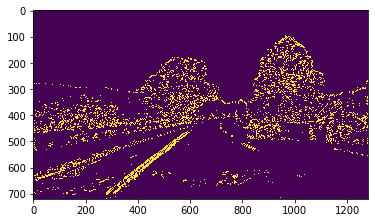

In [4]:
def sobelThreshold(img, orient = 'x', channel = 'R', sobel_kernel = 3, thresh = (0, 255)):
    if channel == 'R':
        img_channel = img[:,:,0]
    elif channel == 'G':
        img_channel = img[:,:,1]
    elif channel == 'H':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,0]    
    elif channel == 'S':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,2]
    else:
        img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)

    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def magThreshold(img, channel = 'R', sobel_kernel = 3, thresh = (0, 255)):
    if channel == 'R':
        img_channel = img[:,:,0]
    elif channel == 'G':
        img_channel = img[:,:,1]
    elif channel == 'H':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,0]    
    elif channel == 'S':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,2]
    else:
        img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dirThreshold(img, channel = 'R', sobel_kernel=3, thresh = (0, np.pi/2)):
    if channel == 'R':
        img_channel = img[:,:,0]
    elif channel == 'G':
        img_channel = img[:,:,1]
    elif channel == 'H':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,0]    
    elif channel == 'S':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,2]
    else:
        img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Example code
sx = sobelThreshold(undist, 'x', 'R', 9, thresh = (20, 100))
sy = sobelThreshold(undist, 'y', 'R', 9, thresh = (20, 100))
magthr = magThreshold(undist, 'S', 9, thresh = (30, 100))
dirthr = dirThreshold(undist, 'S', 15, (0.7, 1.3))

gr_binary = np.zeros_like(sx)
gr_binary[((sx == 1) & (sy == 1)) | ((magthr == 1) & (dirthr == 1))] = 1

plt.imshow(gr_binary)

## Color transform function

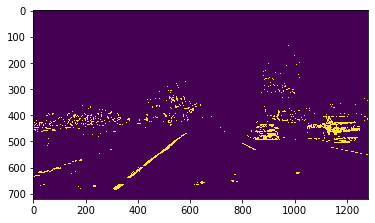

In [5]:
def color_select(img, channel = 'S', thresh=(0, 255)):        
    # Select the channel
    if channel == 'R':
        img_channel = img[:,:,0]
    elif channel == 'G':
        img_channel = img[:,:,1]
    elif channel == 'H':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,0]    
    elif channel == 'S':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,2]
    else:
        img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply a threshold to the channel
    binary_output = np.zeros_like(img_channel)
    binary_output[(img_channel > thresh[0]) & (img_channel <= thresh[1])] = 1

    # Return a binary image of threshold result
    return binary_output

color_binary = color_select(img, 'S', thresh = (170, 255))

plt.imshow(color_binary)

## Combine the gradient and the color transformed images

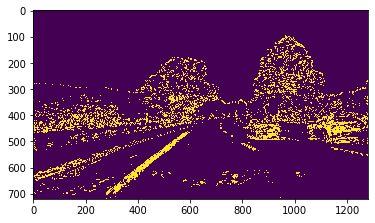

In [6]:
temp_combined_binary = np.zeros_like(color_binary)
temp_combined_binary[(color_binary == 1) | (gr_binary == 1)] = 1

plt.imshow(temp_combined_binary)

## Apply R channel threshold

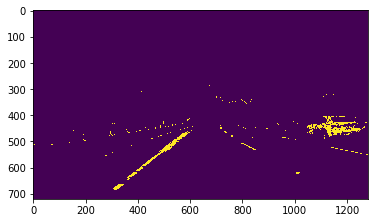

In [7]:
color_binary_r = color_select(img, 'R', thresh = (200, 255))
combined_binary = np.zeros_like(color_binary)
combined_binary[(temp_combined_binary == 1) & (color_binary_r == 1)] = 1

plt.imshow(combined_binary)

## Image finder function

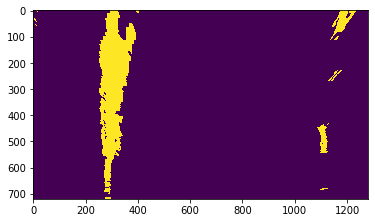

In [8]:
def warpImage(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

binary_warped = warpImage(combined_binary, M)
plt.imshow(binary_warped)

## Lane finder and polynomial fit functions

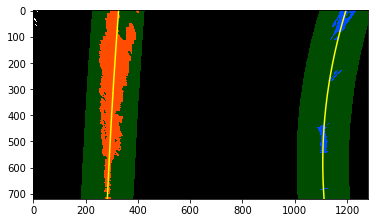

In [9]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
# left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# Visualization function
def line_visualization(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, margin):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area (margins)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # View your output
    plt.imshow(result)

# Function to fit polynomial, used by subsequent functions
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

# Function to find the line and fit the polynomial of the first considered frame
def findLines(binary_warped, visualization = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Visualization
    if(visualization == True):
        line_visualization(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, margin)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

# find Polynomes
left_fit, right_fit, left_fitx, right_fitx, ploty = findLines(binary_warped, visualization = True)

## Drawing

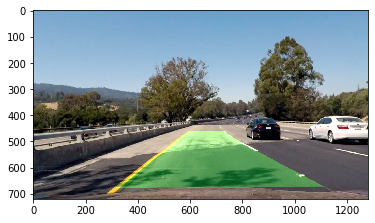

In [10]:
def drawLane(undist, binary_warped, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warpImage(color_warp, Minv) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result
    
result = drawLane(undist, binary_warped, ploty, left_fitx, right_fitx, Minv)
plt.imshow(result)

## Function for subsequent frames

In [11]:
def findSubsequentLines(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & \
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & \
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

## Pipeline

In [12]:
class LaneFinder():
    def __init__(self):
        self.__isFirst = True
        self.__undetected = 0
        self.__left_fit = []
        self.__right_fit = []
        self.__left_fitx = []
        self.__right_fitx = []
        self.__ploty = []

    def process_image(self, img, is_video = True):
        # Undistort the image
        undist = undistortImage(img, "wide_dist_pickle.p")

        # Apply gradient thresholding
        sx = sobelThreshold(undist, 'x', 'R', 9, thresh = (20, 100))
        sy = sobelThreshold(undist, 'y', 'R', 9, thresh = (20, 100))
        magthr = magThreshold(undist, 'S', 9, thresh = (30, 100))
        dirthr = dirThreshold(undist, 'S', 15, (0.7, 1.3))

        gr_binary = np.zeros_like(sx)
        gr_binary[((sx == 1) & (sy == 1)) | ((magthr == 1) & (dirthr == 1))] = 1

        # Apply color thresholding on S channel
        color_binary_s = color_select(img, 'S', thresh = (170, 255))
        color_binary = np.zeros_like(color_binary_s)

        # Combine gradient and color thresholding
        temp_combined_binary = np.zeros_like(color_binary)
        temp_combined_binary[(color_binary == 1) | (gr_binary == 1)] = 1

        # Apply a red channel threshold on the image
        color_binary_r = color_select(img, 'R', thresh = (200, 255))
        combined_binary = np.zeros_like(color_binary)
        combined_binary[(temp_combined_binary == 1) & (color_binary_r == 1)] = 1

        # Warp image
        binary_warped = warpImage(combined_binary, M)

        if(self.__undetected > 5 or self.__isFirst == True or is_video == False):
            # Find polynomes
            print('first line ')
            try:
                self.__left_fit, self.__right_fit, self.__left_fitx, self.__right_fitx, self.__ploty = \
                findLines(binary_warped)
                self.__undetected = 0
                self.__isFirst = False
            except:
                print('undetected')
                self.__undetected += 1
        else:
            print('subsequent line ')
            try:
                self.__left_fit, self.__right_fit, self.__left_fitx, self.__right_fitx, self.__ploty = \
                findSubsequentLines(binary_warped, self.__left_fit, self.__right_fit)
                self.__undetected = 0
            except:
                print('undetected')
                self.__undetected += 1
            
        # Draw lane
        result = drawLane(undist, binary_warped, self.__ploty, self.__left_fitx, self.__right_fitx, Minv)

        return result

## Apply pipeline on images

In [14]:
img_lf = LaneFinder()

input_folder = 'test_images/'
output_folder = 'output_images/'

for fname in os.listdir(input_folder):
    # Read the image
    img = plt.imread(input_folder + fname)
    # Apply the pipeline
    result = img_lf.process_image(img, False)
    # Save the image
    plt.imsave(output_folder + fname, result)

first line 
first line 
first line 
first line 
first line 
first line 
first line 
first line 


## Include libraries for videos

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Apply the pipeline on project video

In [18]:
lf = LaneFinder()

white_output = 'output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lf.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

first line 
[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4



  0%|          | 1/1261 [00:00<07:27,  2.82it/s]

subsequent line 



  0%|          | 2/1261 [00:00<07:34,  2.77it/s]

subsequent line 



  0%|          | 3/1261 [00:01<07:36,  2.76it/s]

subsequent line 



  0%|          | 4/1261 [00:01<07:42,  2.72it/s]

subsequent line 



  0%|          | 5/1261 [00:01<08:07,  2.58it/s]

subsequent line 



  0%|          | 6/1261 [00:02<08:16,  2.53it/s]

subsequent line 



  1%|          | 7/1261 [00:02<07:16,  2.87it/s]

subsequent line 



  1%|          | 8/1261 [00:02<06:51,  3.04it/s]

subsequent line 



  1%|          | 9/1261 [00:03<07:03,  2.95it/s]

subsequent line 



  1%|          | 10/1261 [00:03<07:11,  2.90it/s]

subsequent line 



  1%|          | 11/1261 [00:03<07:15,  2.87it/s]

subsequent line 



  1%|          | 12/1261 [00:04<07:24,  2.81it/s]

subsequent line 



  1%|          | 13/1261 [00:04<08:08,  2.55it/s]

subsequent line 



  1%|          | 14/1261 [00:05<08:07,  2.56it/s]

subsequent line 



  1%|          | 15/1261 [00:05<07:26,  2.79it/s]

subsequent line 



  1%|▏         | 16/1261 [00:05<07:11,  2.89it/s]

subsequent line 



  1%|▏         | 17/1261 [00:06<07:11,  2.88it/s]

subsequent line 



  1%|▏         | 18/1261 [00:06<07:15,  2.86it/s]

subsequent line 



  2%|▏         | 19/1261 [00:06<07:34,  2.73it/s]

subsequent line 



  2%|▏         | 20/1261 [00:07<07:22,  2.81it/s]

subsequent line 



  2%|▏         | 21/1261 [00:07<07:12,  2.87it/s]

subsequent line 



  2%|▏         | 22/1261 [00:07<07:11,  2.87it/s]

subsequent line 



  2%|▏         | 23/1261 [00:08<07:11,  2.87it/s]

subsequent line 



  2%|▏         | 24/1261 [00:08<07:11,  2.87it/s]

subsequent line 



  2%|▏         | 25/1261 [00:08<06:58,  2.95it/s]

subsequent line 



  2%|▏         | 26/1261 [00:09<06:51,  3.00it/s]

subsequent line 



  2%|▏         | 27/1261 [00:09<06:31,  3.15it/s]

subsequent line 



  2%|▏         | 28/1261 [00:09<06:29,  3.17it/s]

subsequent line 



  2%|▏         | 29/1261 [00:10<07:10,  2.86it/s]

subsequent line 



  2%|▏         | 30/1261 [00:10<07:31,  2.73it/s]

subsequent line 



  2%|▏         | 31/1261 [00:11<08:12,  2.50it/s]

subsequent line 



  3%|▎         | 32/1261 [00:11<07:58,  2.57it/s]

subsequent line 



  3%|▎         | 33/1261 [00:11<08:04,  2.54it/s]

subsequent line 



  3%|▎         | 34/1261 [00:12<07:20,  2.79it/s]

subsequent line 



  3%|▎         | 35/1261 [00:12<07:00,  2.92it/s]

subsequent line 



  3%|▎         | 36/1261 [00:12<06:48,  3.00it/s]

subsequent line 



  3%|▎         | 37/1261 [00:13<06:51,  2.97it/s]

subsequent line 



  3%|▎         | 38/1261 [00:13<07:33,  2.70it/s]

subsequent line 



  3%|▎         | 39/1261 [00:13<07:41,  2.65it/s]

subsequent line 



  3%|▎         | 40/1261 [00:14<07:21,  2.76it/s]

subsequent line 



  3%|▎         | 41/1261 [00:14<06:44,  3.01it/s]

subsequent line 



  3%|▎         | 42/1261 [00:14<06:18,  3.22it/s]

subsequent line 



  3%|▎         | 43/1261 [00:15<06:36,  3.07it/s]

subsequent line 



  3%|▎         | 44/1261 [00:15<06:43,  3.01it/s]

subsequent line 



  4%|▎         | 45/1261 [00:15<06:45,  3.00it/s]

subsequent line 



  4%|▎         | 46/1261 [00:16<06:46,  2.99it/s]

subsequent line 



  4%|▎         | 47/1261 [00:16<06:57,  2.91it/s]

subsequent line 



  4%|▍         | 48/1261 [00:16<07:02,  2.87it/s]

subsequent line 



  4%|▍         | 49/1261 [00:17<06:52,  2.94it/s]

subsequent line 



  4%|▍         | 50/1261 [00:17<06:37,  3.04it/s]

subsequent line 



  4%|▍         | 51/1261 [00:17<06:16,  3.21it/s]

subsequent line 



  4%|▍         | 52/1261 [00:18<06:11,  3.25it/s]

subsequent line 



  4%|▍         | 53/1261 [00:18<06:22,  3.16it/s]

subsequent line 



  4%|▍         | 54/1261 [00:18<06:38,  3.03it/s]

subsequent line 



  4%|▍         | 55/1261 [00:19<07:08,  2.81it/s]

subsequent line 



  4%|▍         | 56/1261 [00:19<06:48,  2.95it/s]

subsequent line 



  5%|▍         | 57/1261 [00:19<06:25,  3.13it/s]

subsequent line 



  5%|▍         | 58/1261 [00:20<06:41,  3.00it/s]

subsequent line 



  5%|▍         | 59/1261 [00:20<06:53,  2.91it/s]

subsequent line 



  5%|▍         | 60/1261 [00:20<07:21,  2.72it/s]

subsequent line 



  5%|▍         | 61/1261 [00:21<07:17,  2.74it/s]

subsequent line 



  5%|▍         | 62/1261 [00:21<07:29,  2.67it/s]

subsequent line 



  5%|▍         | 63/1261 [00:22<07:37,  2.62it/s]

subsequent line 



  5%|▌         | 64/1261 [00:22<07:55,  2.52it/s]

subsequent line 



  5%|▌         | 65/1261 [00:23<08:20,  2.39it/s]

subsequent line 



  5%|▌         | 66/1261 [00:23<07:52,  2.53it/s]

subsequent line 



  5%|▌         | 67/1261 [00:23<07:09,  2.78it/s]

subsequent line 



  5%|▌         | 68/1261 [00:23<06:40,  2.98it/s]

subsequent line 



  5%|▌         | 69/1261 [00:24<06:26,  3.08it/s]

subsequent line 



  6%|▌         | 70/1261 [00:24<06:24,  3.10it/s]

subsequent line 



  6%|▌         | 71/1261 [00:24<06:17,  3.15it/s]

subsequent line 



  6%|▌         | 72/1261 [00:25<06:44,  2.94it/s]

subsequent line 



  6%|▌         | 73/1261 [00:25<06:51,  2.89it/s]

subsequent line 



  6%|▌         | 74/1261 [00:26<07:36,  2.60it/s]

subsequent line 



  6%|▌         | 75/1261 [00:26<08:04,  2.45it/s]

subsequent line 



  6%|▌         | 76/1261 [00:26<07:34,  2.61it/s]

subsequent line 



  6%|▌         | 77/1261 [00:27<07:01,  2.81it/s]

subsequent line 



  6%|▌         | 78/1261 [00:27<06:54,  2.85it/s]

subsequent line 



  6%|▋         | 79/1261 [00:27<06:55,  2.85it/s]

subsequent line 



  6%|▋         | 80/1261 [00:28<07:02,  2.80it/s]

subsequent line 



  6%|▋         | 81/1261 [00:28<06:46,  2.91it/s]

subsequent line 



  7%|▋         | 82/1261 [00:28<06:22,  3.08it/s]

subsequent line 



  7%|▋         | 83/1261 [00:29<06:17,  3.12it/s]

subsequent line 



  7%|▋         | 84/1261 [00:29<06:38,  2.95it/s]

subsequent line 



  7%|▋         | 85/1261 [00:29<07:12,  2.72it/s]

subsequent line 



  7%|▋         | 86/1261 [00:30<07:28,  2.62it/s]

subsequent line 



  7%|▋         | 87/1261 [00:30<06:53,  2.84it/s]

subsequent line 



  7%|▋         | 88/1261 [00:30<06:38,  2.95it/s]

subsequent line 



  7%|▋         | 89/1261 [00:31<06:49,  2.86it/s]

subsequent line 



  7%|▋         | 90/1261 [00:31<07:22,  2.65it/s]

subsequent line 



  7%|▋         | 91/1261 [00:32<07:54,  2.47it/s]

subsequent line 



  7%|▋         | 92/1261 [00:32<07:38,  2.55it/s]

subsequent line 



  7%|▋         | 93/1261 [00:32<07:07,  2.73it/s]

subsequent line 



  7%|▋         | 94/1261 [00:33<07:14,  2.69it/s]

subsequent line 



  8%|▊         | 95/1261 [00:33<07:14,  2.69it/s]

subsequent line 



  8%|▊         | 96/1261 [00:34<07:34,  2.56it/s]

subsequent line 



  8%|▊         | 97/1261 [00:34<06:59,  2.77it/s]

subsequent line 



  8%|▊         | 98/1261 [00:34<06:37,  2.93it/s]

subsequent line 



  8%|▊         | 99/1261 [00:34<06:21,  3.05it/s]

subsequent line 



  8%|▊         | 100/1261 [00:35<06:33,  2.95it/s]

subsequent line 



  8%|▊         | 101/1261 [00:35<06:34,  2.94it/s]

subsequent line 



  8%|▊         | 102/1261 [00:36<07:10,  2.69it/s]

subsequent line 



  8%|▊         | 103/1261 [00:36<07:08,  2.70it/s]

subsequent line 



  8%|▊         | 104/1261 [00:36<07:08,  2.70it/s]

subsequent line 



  8%|▊         | 105/1261 [00:37<07:15,  2.66it/s]

subsequent line 



  8%|▊         | 106/1261 [00:37<06:52,  2.80it/s]

subsequent line 



  8%|▊         | 107/1261 [00:37<06:32,  2.94it/s]

subsequent line 



  9%|▊         | 108/1261 [00:38<06:25,  2.99it/s]

subsequent line 



  9%|▊         | 109/1261 [00:38<07:06,  2.70it/s]

subsequent line 



  9%|▊         | 110/1261 [00:39<07:18,  2.63it/s]

subsequent line 



  9%|▉         | 111/1261 [00:39<07:07,  2.69it/s]

subsequent line 



  9%|▉         | 112/1261 [00:39<06:35,  2.90it/s]

subsequent line 



  9%|▉         | 113/1261 [00:39<06:13,  3.07it/s]

subsequent line 



  9%|▉         | 114/1261 [00:40<06:03,  3.15it/s]

subsequent line 



  9%|▉         | 115/1261 [00:40<06:10,  3.09it/s]

subsequent line 



  9%|▉         | 116/1261 [00:40<06:20,  3.01it/s]

subsequent line 



  9%|▉         | 117/1261 [00:41<06:27,  2.95it/s]

subsequent line 



  9%|▉         | 118/1261 [00:41<06:10,  3.09it/s]

subsequent line 



  9%|▉         | 119/1261 [00:41<05:49,  3.27it/s]

subsequent line 



 10%|▉         | 120/1261 [00:42<05:38,  3.37it/s]

subsequent line 



 10%|▉         | 121/1261 [00:42<05:48,  3.28it/s]

subsequent line 



 10%|▉         | 122/1261 [00:42<05:56,  3.20it/s]

subsequent line 



 10%|▉         | 123/1261 [00:43<06:10,  3.07it/s]

subsequent line 



 10%|▉         | 124/1261 [00:43<06:09,  3.07it/s]

subsequent line 



 10%|▉         | 125/1261 [00:43<05:48,  3.26it/s]

subsequent line 



 10%|▉         | 126/1261 [00:43<05:31,  3.42it/s]

subsequent line 



 10%|█         | 127/1261 [00:44<05:42,  3.32it/s]

subsequent line 



 10%|█         | 128/1261 [00:44<05:55,  3.19it/s]

subsequent line 



 10%|█         | 129/1261 [00:44<06:03,  3.12it/s]

subsequent line 



 10%|█         | 130/1261 [00:45<06:09,  3.06it/s]

subsequent line 



 10%|█         | 131/1261 [00:45<05:49,  3.23it/s]

subsequent line 



 10%|█         | 132/1261 [00:45<05:38,  3.34it/s]

subsequent line 



 11%|█         | 133/1261 [00:46<05:24,  3.48it/s]

subsequent line 



 11%|█         | 134/1261 [00:46<05:41,  3.30it/s]

subsequent line 



 11%|█         | 135/1261 [00:46<06:06,  3.07it/s]

subsequent line 



 11%|█         | 136/1261 [00:47<06:26,  2.91it/s]

subsequent line 



 11%|█         | 137/1261 [00:47<06:10,  3.03it/s]

subsequent line 



 11%|█         | 138/1261 [00:47<06:03,  3.09it/s]

subsequent line 



 11%|█         | 139/1261 [00:48<05:46,  3.24it/s]

subsequent line 



 11%|█         | 140/1261 [00:48<05:45,  3.25it/s]

subsequent line 



 11%|█         | 141/1261 [00:48<05:50,  3.19it/s]

subsequent line 



 11%|█▏        | 142/1261 [00:49<06:01,  3.10it/s]

subsequent line 



 11%|█▏        | 143/1261 [00:49<06:04,  3.06it/s]

subsequent line 



 11%|█▏        | 144/1261 [00:49<05:42,  3.26it/s]

subsequent line 



 11%|█▏        | 145/1261 [00:49<05:27,  3.41it/s]

subsequent line 



 12%|█▏        | 146/1261 [00:50<05:21,  3.47it/s]

subsequent line 



 12%|█▏        | 147/1261 [00:50<05:36,  3.31it/s]

subsequent line 



 12%|█▏        | 148/1261 [00:50<05:52,  3.16it/s]

subsequent line 



 12%|█▏        | 149/1261 [00:51<06:12,  2.98it/s]

subsequent line 



 12%|█▏        | 150/1261 [00:51<06:03,  3.06it/s]

subsequent line 



 12%|█▏        | 151/1261 [00:51<05:53,  3.14it/s]

subsequent line 



 12%|█▏        | 152/1261 [00:52<05:37,  3.29it/s]

subsequent line 



 12%|█▏        | 153/1261 [00:52<05:39,  3.27it/s]

subsequent line 



 12%|█▏        | 154/1261 [00:52<05:47,  3.19it/s]

subsequent line 



 12%|█▏        | 155/1261 [00:53<06:03,  3.04it/s]

subsequent line 



 12%|█▏        | 156/1261 [00:53<06:07,  3.00it/s]

subsequent line 



 12%|█▏        | 157/1261 [00:53<05:45,  3.20it/s]

subsequent line 



 13%|█▎        | 158/1261 [00:54<05:30,  3.34it/s]

subsequent line 



 13%|█▎        | 159/1261 [00:54<05:24,  3.40it/s]

subsequent line 



 13%|█▎        | 160/1261 [00:54<05:32,  3.31it/s]

subsequent line 



 13%|█▎        | 161/1261 [00:54<05:35,  3.28it/s]

subsequent line 



 13%|█▎        | 162/1261 [00:55<05:44,  3.19it/s]

subsequent line 



 13%|█▎        | 163/1261 [00:55<05:43,  3.19it/s]

subsequent line 



 13%|█▎        | 164/1261 [00:55<05:28,  3.34it/s]

subsequent line 



 13%|█▎        | 165/1261 [00:56<05:10,  3.53it/s]

subsequent line 



 13%|█▎        | 166/1261 [00:56<05:32,  3.30it/s]

subsequent line 



 13%|█▎        | 167/1261 [00:56<05:39,  3.22it/s]

subsequent line 



 13%|█▎        | 168/1261 [00:57<05:53,  3.09it/s]

subsequent line 



 13%|█▎        | 169/1261 [00:57<05:50,  3.11it/s]

subsequent line 



 13%|█▎        | 170/1261 [00:57<05:41,  3.20it/s]

subsequent line 



 14%|█▎        | 171/1261 [00:58<05:26,  3.34it/s]

subsequent line 



 14%|█▎        | 172/1261 [00:58<05:21,  3.39it/s]

subsequent line 



 14%|█▎        | 173/1261 [00:58<05:47,  3.13it/s]

subsequent line 



 14%|█▍        | 174/1261 [00:59<05:57,  3.04it/s]

subsequent line 



 14%|█▍        | 175/1261 [00:59<06:10,  2.93it/s]

subsequent line 



 14%|█▍        | 176/1261 [00:59<06:04,  2.98it/s]

subsequent line 



 14%|█▍        | 177/1261 [01:00<05:53,  3.07it/s]

subsequent line 



 14%|█▍        | 178/1261 [01:00<05:34,  3.23it/s]

subsequent line 



 14%|█▍        | 179/1261 [01:00<05:45,  3.13it/s]

subsequent line 



 14%|█▍        | 180/1261 [01:00<05:51,  3.08it/s]

subsequent line 



 14%|█▍        | 181/1261 [01:01<05:52,  3.06it/s]

subsequent line 



 14%|█▍        | 182/1261 [01:01<05:52,  3.06it/s]

subsequent line 



 15%|█▍        | 183/1261 [01:01<05:41,  3.16it/s]

subsequent line 



 15%|█▍        | 184/1261 [01:02<05:28,  3.28it/s]

subsequent line 



 15%|█▍        | 185/1261 [01:02<05:24,  3.31it/s]

subsequent line 



 15%|█▍        | 186/1261 [01:02<05:37,  3.18it/s]

subsequent line 



 15%|█▍        | 187/1261 [01:03<05:48,  3.08it/s]

subsequent line 



 15%|█▍        | 188/1261 [01:03<05:51,  3.05it/s]

subsequent line 



 15%|█▍        | 189/1261 [01:03<05:38,  3.17it/s]

subsequent line 



 15%|█▌        | 190/1261 [01:04<05:26,  3.28it/s]

subsequent line 



 15%|█▌        | 191/1261 [01:04<05:30,  3.24it/s]

subsequent line 



 15%|█▌        | 192/1261 [01:04<06:14,  2.85it/s]

subsequent line 



 15%|█▌        | 193/1261 [01:05<06:33,  2.71it/s]

subsequent line 



 15%|█▌        | 194/1261 [01:05<06:43,  2.65it/s]

subsequent line 



 15%|█▌        | 195/1261 [01:06<06:32,  2.71it/s]

subsequent line 



 16%|█▌        | 196/1261 [01:06<06:14,  2.85it/s]

subsequent line 



 16%|█▌        | 197/1261 [01:06<06:16,  2.82it/s]

subsequent line 



 16%|█▌        | 198/1261 [01:07<06:17,  2.81it/s]

subsequent line 



 16%|█▌        | 199/1261 [01:07<06:23,  2.77it/s]

subsequent line 



 16%|█▌        | 200/1261 [01:07<06:14,  2.83it/s]

subsequent line 



 16%|█▌        | 201/1261 [01:08<05:53,  3.00it/s]

subsequent line 



 16%|█▌        | 202/1261 [01:08<05:34,  3.17it/s]

subsequent line 



 16%|█▌        | 203/1261 [01:08<05:28,  3.22it/s]

subsequent line 



 16%|█▌        | 204/1261 [01:08<05:32,  3.17it/s]

subsequent line 



 16%|█▋        | 205/1261 [01:09<05:41,  3.09it/s]

subsequent line 



 16%|█▋        | 206/1261 [01:09<05:51,  3.00it/s]

subsequent line 



 16%|█▋        | 207/1261 [01:09<05:30,  3.19it/s]

subsequent line 



 16%|█▋        | 208/1261 [01:10<05:15,  3.34it/s]

subsequent line 



 17%|█▋        | 209/1261 [01:10<05:05,  3.45it/s]

subsequent line 



 17%|█▋        | 210/1261 [01:10<05:16,  3.32it/s]

subsequent line 



 17%|█▋        | 211/1261 [01:11<05:33,  3.14it/s]

subsequent line 



 17%|█▋        | 212/1261 [01:11<05:59,  2.92it/s]

subsequent line 



 17%|█▋        | 213/1261 [01:11<05:38,  3.09it/s]

subsequent line 



 17%|█▋        | 214/1261 [01:12<05:35,  3.12it/s]

subsequent line 



 17%|█▋        | 215/1261 [01:12<05:26,  3.20it/s]

subsequent line 



 17%|█▋        | 216/1261 [01:12<05:43,  3.04it/s]

subsequent line 



 17%|█▋        | 217/1261 [01:13<05:52,  2.96it/s]

subsequent line 



 17%|█▋        | 218/1261 [01:13<06:01,  2.88it/s]

subsequent line 



 17%|█▋        | 219/1261 [01:13<06:04,  2.86it/s]

subsequent line 



 17%|█▋        | 220/1261 [01:14<05:43,  3.03it/s]

subsequent line 



 18%|█▊        | 221/1261 [01:14<05:27,  3.17it/s]

subsequent line 



 18%|█▊        | 222/1261 [01:14<05:49,  2.97it/s]

subsequent line 



 18%|█▊        | 223/1261 [01:15<05:49,  2.97it/s]

subsequent line 



 18%|█▊        | 224/1261 [01:15<05:51,  2.95it/s]

subsequent line 



 18%|█▊        | 225/1261 [01:15<05:43,  3.02it/s]

subsequent line 



 18%|█▊        | 226/1261 [01:16<05:28,  3.15it/s]

subsequent line 



 18%|█▊        | 227/1261 [01:16<05:14,  3.29it/s]

subsequent line 



 18%|█▊        | 228/1261 [01:16<05:14,  3.28it/s]

subsequent line 



 18%|█▊        | 229/1261 [01:17<05:20,  3.22it/s]

subsequent line 



 18%|█▊        | 230/1261 [01:17<05:29,  3.13it/s]

subsequent line 



 18%|█▊        | 231/1261 [01:17<05:47,  2.97it/s]

subsequent line 



 18%|█▊        | 232/1261 [01:18<05:39,  3.03it/s]

subsequent line 



 18%|█▊        | 233/1261 [01:18<05:17,  3.23it/s]

subsequent line 



 19%|█▊        | 234/1261 [01:18<05:14,  3.27it/s]

subsequent line 



 19%|█▊        | 235/1261 [01:18<05:19,  3.21it/s]

subsequent line 



 19%|█▊        | 236/1261 [01:19<06:02,  2.83it/s]

subsequent line 



 19%|█▉        | 237/1261 [01:19<06:06,  2.79it/s]

subsequent line 



 19%|█▉        | 238/1261 [01:20<05:44,  2.97it/s]

subsequent line 



 19%|█▉        | 239/1261 [01:20<05:22,  3.17it/s]

subsequent line 



 19%|█▉        | 240/1261 [01:20<05:20,  3.19it/s]

subsequent line 



 19%|█▉        | 241/1261 [01:20<05:28,  3.11it/s]

subsequent line 



 19%|█▉        | 242/1261 [01:21<05:44,  2.96it/s]

subsequent line 



 19%|█▉        | 243/1261 [01:21<06:01,  2.82it/s]

subsequent line 



 19%|█▉        | 244/1261 [01:22<05:41,  2.98it/s]

subsequent line 



 19%|█▉        | 245/1261 [01:22<05:26,  3.11it/s]

subsequent line 



 20%|█▉        | 246/1261 [01:22<05:20,  3.17it/s]

subsequent line 



 20%|█▉        | 247/1261 [01:22<05:36,  3.02it/s]

subsequent line 



 20%|█▉        | 248/1261 [01:23<05:50,  2.89it/s]

subsequent line 



 20%|█▉        | 249/1261 [01:23<05:58,  2.82it/s]

subsequent line 



 20%|█▉        | 250/1261 [01:24<05:41,  2.96it/s]

subsequent line 



 20%|█▉        | 251/1261 [01:24<05:18,  3.17it/s]

subsequent line 



 20%|█▉        | 252/1261 [01:24<05:04,  3.31it/s]

subsequent line 



 20%|██        | 253/1261 [01:24<05:20,  3.15it/s]

subsequent line 



 20%|██        | 254/1261 [01:25<05:32,  3.02it/s]

subsequent line 



 20%|██        | 255/1261 [01:25<05:43,  2.93it/s]

subsequent line 



 20%|██        | 256/1261 [01:25<05:38,  2.97it/s]

subsequent line 



 20%|██        | 257/1261 [01:26<05:24,  3.10it/s]

subsequent line 



 20%|██        | 258/1261 [01:26<05:10,  3.23it/s]

subsequent line 



 21%|██        | 259/1261 [01:26<05:12,  3.20it/s]

subsequent line 



 21%|██        | 260/1261 [01:27<05:15,  3.17it/s]

subsequent line 



 21%|██        | 261/1261 [01:27<05:17,  3.15it/s]

subsequent line 



 21%|██        | 262/1261 [01:27<05:27,  3.05it/s]

subsequent line 



 21%|██        | 263/1261 [01:28<05:11,  3.21it/s]

subsequent line 



 21%|██        | 264/1261 [01:28<05:05,  3.26it/s]

subsequent line 



 21%|██        | 265/1261 [01:28<04:59,  3.33it/s]

subsequent line 



 21%|██        | 266/1261 [01:29<05:06,  3.24it/s]

subsequent line 



 21%|██        | 267/1261 [01:29<05:20,  3.10it/s]

subsequent line 



 21%|██▏       | 268/1261 [01:29<05:44,  2.88it/s]

subsequent line 



 21%|██▏       | 269/1261 [01:30<05:39,  2.92it/s]

subsequent line 



 21%|██▏       | 270/1261 [01:30<05:21,  3.08it/s]

subsequent line 



 21%|██▏       | 271/1261 [01:30<05:06,  3.23it/s]

subsequent line 



 22%|██▏       | 272/1261 [01:31<05:09,  3.19it/s]

subsequent line 



 22%|██▏       | 273/1261 [01:31<05:12,  3.16it/s]

subsequent line 



 22%|██▏       | 274/1261 [01:31<05:24,  3.04it/s]

subsequent line 



 22%|██▏       | 275/1261 [01:31<05:18,  3.10it/s]

subsequent line 



 22%|██▏       | 276/1261 [01:32<05:14,  3.13it/s]

subsequent line 



 22%|██▏       | 277/1261 [01:32<05:00,  3.27it/s]

subsequent line 



 22%|██▏       | 278/1261 [01:32<05:06,  3.20it/s]

subsequent line 



 22%|██▏       | 279/1261 [01:33<05:22,  3.05it/s]

subsequent line 



 22%|██▏       | 280/1261 [01:33<05:55,  2.76it/s]

subsequent line 



 22%|██▏       | 281/1261 [01:34<05:41,  2.87it/s]

subsequent line 



 22%|██▏       | 282/1261 [01:34<05:43,  2.85it/s]

subsequent line 



 22%|██▏       | 283/1261 [01:34<05:43,  2.85it/s]

subsequent line 



 23%|██▎       | 284/1261 [01:35<05:49,  2.80it/s]

subsequent line 



 23%|██▎       | 285/1261 [01:35<06:05,  2.67it/s]

subsequent line 



 23%|██▎       | 286/1261 [01:35<05:59,  2.71it/s]

subsequent line 



 23%|██▎       | 287/1261 [01:36<05:41,  2.86it/s]

subsequent line 



 23%|██▎       | 288/1261 [01:36<05:12,  3.12it/s]

subsequent line 



 23%|██▎       | 289/1261 [01:36<04:51,  3.33it/s]

subsequent line 



 23%|██▎       | 290/1261 [01:37<05:06,  3.16it/s]

subsequent line 



 23%|██▎       | 291/1261 [01:37<05:15,  3.08it/s]

subsequent line 



 23%|██▎       | 292/1261 [01:37<05:17,  3.05it/s]

subsequent line 



 23%|██▎       | 293/1261 [01:38<05:45,  2.80it/s]

subsequent line 



 23%|██▎       | 294/1261 [01:38<05:21,  3.01it/s]

subsequent line 



 23%|██▎       | 295/1261 [01:38<05:00,  3.21it/s]

subsequent line 



 23%|██▎       | 296/1261 [01:39<05:06,  3.14it/s]

subsequent line 



 24%|██▎       | 297/1261 [01:39<05:08,  3.13it/s]

subsequent line 



 24%|██▎       | 298/1261 [01:39<05:16,  3.05it/s]

subsequent line 



 24%|██▎       | 299/1261 [01:40<05:18,  3.02it/s]

subsequent line 



 24%|██▍       | 300/1261 [01:40<05:05,  3.15it/s]

subsequent line 



 24%|██▍       | 301/1261 [01:40<04:42,  3.40it/s]

subsequent line 



 24%|██▍       | 302/1261 [01:40<04:36,  3.46it/s]

subsequent line 



 24%|██▍       | 303/1261 [01:41<04:56,  3.24it/s]

subsequent line 



 24%|██▍       | 304/1261 [01:41<05:14,  3.04it/s]

subsequent line 



 24%|██▍       | 305/1261 [01:41<05:25,  2.94it/s]

subsequent line 



 24%|██▍       | 306/1261 [01:42<05:15,  3.03it/s]

subsequent line 



 24%|██▍       | 307/1261 [01:42<04:56,  3.22it/s]

subsequent line 



 24%|██▍       | 308/1261 [01:42<04:40,  3.39it/s]

subsequent line 



 25%|██▍       | 309/1261 [01:43<04:40,  3.40it/s]

subsequent line 



 25%|██▍       | 310/1261 [01:43<04:48,  3.30it/s]

subsequent line 



 25%|██▍       | 311/1261 [01:43<04:54,  3.23it/s]

subsequent line 



 25%|██▍       | 312/1261 [01:44<04:56,  3.20it/s]

subsequent line 



 25%|██▍       | 313/1261 [01:44<04:45,  3.32it/s]

subsequent line 



 25%|██▍       | 314/1261 [01:44<04:38,  3.40it/s]

subsequent line 



 25%|██▍       | 315/1261 [01:44<04:28,  3.52it/s]

subsequent line 



 25%|██▌       | 316/1261 [01:45<04:38,  3.39it/s]

subsequent line 



 25%|██▌       | 317/1261 [01:45<04:55,  3.20it/s]

subsequent line 



 25%|██▌       | 318/1261 [01:45<05:08,  3.06it/s]

subsequent line 



 25%|██▌       | 319/1261 [01:46<04:56,  3.18it/s]

subsequent line 



 25%|██▌       | 320/1261 [01:46<04:43,  3.32it/s]

subsequent line 



 25%|██▌       | 321/1261 [01:46<04:31,  3.46it/s]

subsequent line 



 26%|██▌       | 322/1261 [01:47<04:40,  3.34it/s]

subsequent line 



 26%|██▌       | 323/1261 [01:47<04:47,  3.26it/s]

subsequent line 



 26%|██▌       | 324/1261 [01:47<05:01,  3.10it/s]

subsequent line 



 26%|██▌       | 325/1261 [01:48<05:08,  3.03it/s]

subsequent line 



 26%|██▌       | 326/1261 [01:48<05:01,  3.10it/s]

subsequent line 



 26%|██▌       | 327/1261 [01:48<04:44,  3.28it/s]

subsequent line 



 26%|██▌       | 328/1261 [01:48<04:35,  3.38it/s]

subsequent line 



 26%|██▌       | 329/1261 [01:49<04:42,  3.30it/s]

subsequent line 



 26%|██▌       | 330/1261 [01:49<04:48,  3.23it/s]

subsequent line 



 26%|██▌       | 331/1261 [01:49<04:51,  3.19it/s]

subsequent line 



 26%|██▋       | 332/1261 [01:50<04:52,  3.17it/s]

subsequent line 



 26%|██▋       | 333/1261 [01:50<04:42,  3.29it/s]

subsequent line 



 26%|██▋       | 334/1261 [01:50<04:37,  3.34it/s]

subsequent line 



 27%|██▋       | 335/1261 [01:51<04:31,  3.41it/s]

subsequent line 



 27%|██▋       | 336/1261 [01:51<04:40,  3.30it/s]

subsequent line 



 27%|██▋       | 337/1261 [01:51<04:47,  3.22it/s]

subsequent line 



 27%|██▋       | 338/1261 [01:52<04:56,  3.11it/s]

subsequent line 



 27%|██▋       | 339/1261 [01:52<04:55,  3.12it/s]

subsequent line 



 27%|██▋       | 340/1261 [01:52<04:45,  3.23it/s]

subsequent line 



 27%|██▋       | 341/1261 [01:52<04:30,  3.40it/s]

subsequent line 



 27%|██▋       | 342/1261 [01:53<04:32,  3.37it/s]

subsequent line 



 27%|██▋       | 343/1261 [01:53<04:36,  3.32it/s]

subsequent line 



 27%|██▋       | 344/1261 [01:53<04:43,  3.23it/s]

subsequent line 



 27%|██▋       | 345/1261 [01:54<04:45,  3.21it/s]

subsequent line 



 27%|██▋       | 346/1261 [01:54<04:51,  3.14it/s]

subsequent line 



 28%|██▊       | 347/1261 [01:54<04:39,  3.27it/s]

subsequent line 



 28%|██▊       | 348/1261 [01:55<04:34,  3.32it/s]

subsequent line 



 28%|██▊       | 349/1261 [01:55<04:36,  3.29it/s]

subsequent line 



 28%|██▊       | 350/1261 [01:55<04:43,  3.21it/s]

subsequent line 



 28%|██▊       | 351/1261 [01:56<04:49,  3.14it/s]

subsequent line 



 28%|██▊       | 352/1261 [01:56<04:46,  3.18it/s]

subsequent line 



 28%|██▊       | 353/1261 [01:56<04:36,  3.28it/s]

subsequent line 



 28%|██▊       | 354/1261 [01:56<04:30,  3.36it/s]

subsequent line 



 28%|██▊       | 355/1261 [01:57<04:31,  3.33it/s]

subsequent line 



 28%|██▊       | 356/1261 [01:57<04:37,  3.27it/s]

subsequent line 



 28%|██▊       | 357/1261 [01:57<04:55,  3.06it/s]

subsequent line 



 28%|██▊       | 358/1261 [01:58<04:54,  3.06it/s]

subsequent line 



 28%|██▊       | 359/1261 [01:58<04:47,  3.14it/s]

subsequent line 



 29%|██▊       | 360/1261 [01:58<04:35,  3.27it/s]

subsequent line 



 29%|██▊       | 361/1261 [01:59<04:35,  3.26it/s]

subsequent line 



 29%|██▊       | 362/1261 [01:59<04:40,  3.20it/s]

subsequent line 



 29%|██▉       | 363/1261 [01:59<04:48,  3.11it/s]

subsequent line 



 29%|██▉       | 364/1261 [02:00<05:05,  2.94it/s]

subsequent line 



 29%|██▉       | 365/1261 [02:00<04:44,  3.14it/s]

subsequent line 



 29%|██▉       | 366/1261 [02:00<04:32,  3.28it/s]

subsequent line 



 29%|██▉       | 367/1261 [02:00<04:23,  3.40it/s]

subsequent line 



 29%|██▉       | 368/1261 [02:01<04:37,  3.22it/s]

subsequent line 



 29%|██▉       | 369/1261 [02:01<04:39,  3.19it/s]

subsequent line 



 29%|██▉       | 370/1261 [02:01<04:53,  3.04it/s]

subsequent line 



 29%|██▉       | 371/1261 [02:02<04:49,  3.07it/s]

subsequent line 



 30%|██▉       | 372/1261 [02:02<04:34,  3.24it/s]

subsequent line 



 30%|██▉       | 373/1261 [02:02<04:22,  3.38it/s]

subsequent line 



 30%|██▉       | 374/1261 [02:03<04:27,  3.32it/s]

subsequent line 



 30%|██▉       | 375/1261 [02:03<04:38,  3.18it/s]

subsequent line 



 30%|██▉       | 376/1261 [02:03<04:46,  3.09it/s]

subsequent line 



 30%|██▉       | 377/1261 [02:04<04:49,  3.05it/s]

subsequent line 



 30%|██▉       | 378/1261 [02:04<04:42,  3.13it/s]

subsequent line 



 30%|███       | 379/1261 [02:04<04:28,  3.29it/s]

subsequent line 



 30%|███       | 380/1261 [02:05<04:19,  3.39it/s]

subsequent line 



 30%|███       | 381/1261 [02:05<04:24,  3.33it/s]

subsequent line 



 30%|███       | 382/1261 [02:05<04:38,  3.16it/s]

subsequent line 



 30%|███       | 383/1261 [02:06<04:50,  3.03it/s]

subsequent line 



 30%|███       | 384/1261 [02:06<04:58,  2.94it/s]

subsequent line 



 31%|███       | 385/1261 [02:06<04:46,  3.06it/s]

subsequent line 



 31%|███       | 386/1261 [02:07<04:36,  3.17it/s]

subsequent line 



 31%|███       | 387/1261 [02:07<04:38,  3.14it/s]

subsequent line 



 31%|███       | 388/1261 [02:07<04:47,  3.04it/s]

subsequent line 



 31%|███       | 389/1261 [02:08<05:31,  2.63it/s]

subsequent line 



 31%|███       | 390/1261 [02:08<05:21,  2.71it/s]

subsequent line 



 31%|███       | 391/1261 [02:08<04:58,  2.92it/s]

subsequent line 



 31%|███       | 392/1261 [02:09<04:54,  2.95it/s]

subsequent line 



 31%|███       | 393/1261 [02:09<05:20,  2.71it/s]

subsequent line 



 31%|███       | 394/1261 [02:09<05:27,  2.65it/s]

subsequent line 



 31%|███▏      | 395/1261 [02:10<05:19,  2.71it/s]

subsequent line 



 31%|███▏      | 396/1261 [02:10<04:57,  2.91it/s]

subsequent line 



 31%|███▏      | 397/1261 [02:10<04:39,  3.09it/s]

subsequent line 



 32%|███▏      | 398/1261 [02:11<04:38,  3.10it/s]

subsequent line 



 32%|███▏      | 399/1261 [02:11<04:37,  3.11it/s]

subsequent line 



 32%|███▏      | 400/1261 [02:11<04:45,  3.02it/s]

subsequent line 



 32%|███▏      | 401/1261 [02:12<04:54,  2.92it/s]

subsequent line 



 32%|███▏      | 402/1261 [02:12<04:42,  3.04it/s]

subsequent line 



 32%|███▏      | 403/1261 [02:12<04:26,  3.23it/s]

subsequent line 



 32%|███▏      | 404/1261 [02:13<04:17,  3.32it/s]

subsequent line 



 32%|███▏      | 405/1261 [02:13<04:23,  3.25it/s]

subsequent line 



 32%|███▏      | 406/1261 [02:13<04:31,  3.15it/s]

subsequent line 



 32%|███▏      | 407/1261 [02:14<04:41,  3.03it/s]

subsequent line 



 32%|███▏      | 408/1261 [02:14<04:32,  3.13it/s]

subsequent line 



 32%|███▏      | 409/1261 [02:14<04:24,  3.22it/s]

subsequent line 



 33%|███▎      | 410/1261 [02:14<04:17,  3.31it/s]

subsequent line 



 33%|███▎      | 411/1261 [02:15<04:19,  3.27it/s]

subsequent line 



 33%|███▎      | 412/1261 [02:15<04:27,  3.17it/s]

subsequent line 



 33%|███▎      | 413/1261 [02:15<04:37,  3.06it/s]

subsequent line 



 33%|███▎      | 414/1261 [02:16<04:44,  2.98it/s]

subsequent line 



 33%|███▎      | 415/1261 [02:16<04:31,  3.12it/s]

subsequent line 



 33%|███▎      | 416/1261 [02:16<04:18,  3.27it/s]

subsequent line 



 33%|███▎      | 417/1261 [02:17<04:18,  3.27it/s]

subsequent line 



 33%|███▎      | 418/1261 [02:17<04:20,  3.23it/s]

subsequent line 



 33%|███▎      | 419/1261 [02:17<04:24,  3.19it/s]

subsequent line 



 33%|███▎      | 420/1261 [02:18<04:32,  3.09it/s]

subsequent line 



 33%|███▎      | 421/1261 [02:18<04:28,  3.12it/s]

subsequent line 



 33%|███▎      | 422/1261 [02:18<04:18,  3.25it/s]

subsequent line 



 34%|███▎      | 423/1261 [02:19<04:08,  3.38it/s]

subsequent line 



 34%|███▎      | 424/1261 [02:19<04:21,  3.20it/s]

subsequent line 



 34%|███▎      | 425/1261 [02:19<04:33,  3.06it/s]

subsequent line 



 34%|███▍      | 426/1261 [02:20<05:01,  2.77it/s]

subsequent line 



 34%|███▍      | 427/1261 [02:20<04:40,  2.97it/s]

subsequent line 



 34%|███▍      | 428/1261 [02:20<04:28,  3.10it/s]

subsequent line 



 34%|███▍      | 429/1261 [02:21<04:16,  3.24it/s]

subsequent line 



 34%|███▍      | 430/1261 [02:21<04:26,  3.12it/s]

subsequent line 



 34%|███▍      | 431/1261 [02:21<04:34,  3.02it/s]

subsequent line 



 34%|███▍      | 432/1261 [02:22<04:47,  2.88it/s]

subsequent line 



 34%|███▍      | 433/1261 [02:22<04:38,  2.97it/s]

subsequent line 



 34%|███▍      | 434/1261 [02:22<04:22,  3.15it/s]

subsequent line 



 34%|███▍      | 435/1261 [02:22<04:08,  3.33it/s]

subsequent line 



 35%|███▍      | 436/1261 [02:23<04:08,  3.33it/s]

subsequent line 



 35%|███▍      | 437/1261 [02:23<04:16,  3.21it/s]

subsequent line 



 35%|███▍      | 438/1261 [02:23<04:22,  3.14it/s]

subsequent line 



 35%|███▍      | 439/1261 [02:24<04:24,  3.11it/s]

subsequent line 



 35%|███▍      | 440/1261 [02:24<04:11,  3.26it/s]

subsequent line 



 35%|███▍      | 441/1261 [02:24<04:05,  3.34it/s]

subsequent line 



 35%|███▌      | 442/1261 [02:25<04:04,  3.36it/s]

subsequent line 



 35%|███▌      | 443/1261 [02:25<04:12,  3.24it/s]

subsequent line 



 35%|███▌      | 444/1261 [02:25<04:21,  3.12it/s]

subsequent line 



 35%|███▌      | 445/1261 [02:26<04:48,  2.82it/s]

subsequent line 



 35%|███▌      | 446/1261 [02:26<04:51,  2.80it/s]

subsequent line 



 35%|███▌      | 447/1261 [02:26<04:36,  2.94it/s]

subsequent line 



 36%|███▌      | 448/1261 [02:27<04:28,  3.03it/s]

subsequent line 



 36%|███▌      | 449/1261 [02:27<04:32,  2.98it/s]

subsequent line 



 36%|███▌      | 450/1261 [02:27<04:40,  2.89it/s]

subsequent line 



 36%|███▌      | 451/1261 [02:28<04:38,  2.91it/s]

subsequent line 



 36%|███▌      | 452/1261 [02:28<04:26,  3.03it/s]

subsequent line 



 36%|███▌      | 453/1261 [02:28<04:13,  3.19it/s]

subsequent line 



 36%|███▌      | 454/1261 [02:29<04:02,  3.33it/s]

subsequent line 



 36%|███▌      | 455/1261 [02:29<04:05,  3.29it/s]

subsequent line 



 36%|███▌      | 456/1261 [02:29<04:11,  3.21it/s]

subsequent line 



 36%|███▌      | 457/1261 [02:30<04:24,  3.04it/s]

subsequent line 



 36%|███▋      | 458/1261 [02:30<04:27,  3.00it/s]

subsequent line 



 36%|███▋      | 459/1261 [02:30<04:13,  3.16it/s]

subsequent line 



 36%|███▋      | 460/1261 [02:31<04:01,  3.32it/s]

subsequent line 



 37%|███▋      | 461/1261 [02:31<04:02,  3.30it/s]

subsequent line 



 37%|███▋      | 462/1261 [02:31<04:07,  3.23it/s]

subsequent line 



 37%|███▋      | 463/1261 [02:31<04:10,  3.18it/s]

subsequent line 



 37%|███▋      | 464/1261 [02:32<04:17,  3.10it/s]

subsequent line 



 37%|███▋      | 465/1261 [02:32<04:05,  3.24it/s]

subsequent line 



 37%|███▋      | 466/1261 [02:32<03:57,  3.35it/s]

subsequent line 



 37%|███▋      | 467/1261 [02:33<03:47,  3.48it/s]

subsequent line 



 37%|███▋      | 468/1261 [02:33<04:01,  3.29it/s]

subsequent line 



 37%|███▋      | 469/1261 [02:33<04:08,  3.18it/s]

subsequent line 



 37%|███▋      | 470/1261 [02:34<04:14,  3.11it/s]

subsequent line 



 37%|███▋      | 471/1261 [02:34<04:13,  3.12it/s]

subsequent line 



 37%|███▋      | 472/1261 [02:34<04:05,  3.21it/s]

subsequent line 



 38%|███▊      | 473/1261 [02:35<03:52,  3.39it/s]

subsequent line 



 38%|███▊      | 474/1261 [02:35<04:04,  3.22it/s]

subsequent line 



 38%|███▊      | 475/1261 [02:35<04:08,  3.16it/s]

subsequent line 



 38%|███▊      | 476/1261 [02:36<04:18,  3.03it/s]

subsequent line 



 38%|███▊      | 477/1261 [02:36<04:14,  3.08it/s]

subsequent line 



 38%|███▊      | 478/1261 [02:36<04:05,  3.19it/s]

subsequent line 



 38%|███▊      | 479/1261 [02:36<03:53,  3.35it/s]

subsequent line 



 38%|███▊      | 480/1261 [02:37<03:50,  3.38it/s]

subsequent line 



 38%|███▊      | 481/1261 [02:37<03:58,  3.28it/s]

subsequent line 



 38%|███▊      | 482/1261 [02:37<04:08,  3.13it/s]

subsequent line 



 38%|███▊      | 483/1261 [02:38<04:20,  2.99it/s]

subsequent line 



 38%|███▊      | 484/1261 [02:38<04:18,  3.01it/s]

subsequent line 



 38%|███▊      | 485/1261 [02:38<04:03,  3.19it/s]

subsequent line 



 39%|███▊      | 486/1261 [02:39<03:52,  3.33it/s]

subsequent line 



 39%|███▊      | 487/1261 [02:39<03:50,  3.36it/s]

subsequent line 



 39%|███▊      | 488/1261 [02:39<03:56,  3.27it/s]

subsequent line 



 39%|███▉      | 489/1261 [02:40<04:04,  3.16it/s]

subsequent line 



 39%|███▉      | 490/1261 [02:40<04:09,  3.08it/s]

subsequent line 



 39%|███▉      | 491/1261 [02:40<04:01,  3.18it/s]

subsequent line 



 39%|███▉      | 492/1261 [02:40<03:53,  3.30it/s]

subsequent line 



 39%|███▉      | 493/1261 [02:41<03:43,  3.44it/s]

subsequent line 



 39%|███▉      | 494/1261 [02:41<03:57,  3.23it/s]

subsequent line 



 39%|███▉      | 495/1261 [02:41<04:08,  3.08it/s]

subsequent line 



 39%|███▉      | 496/1261 [02:42<04:21,  2.93it/s]

subsequent line 



 39%|███▉      | 497/1261 [02:42<04:11,  3.04it/s]

subsequent line 



 39%|███▉      | 498/1261 [02:42<03:59,  3.18it/s]

subsequent line 



 40%|███▉      | 499/1261 [02:43<03:45,  3.38it/s]

subsequent line 



 40%|███▉      | 500/1261 [02:43<03:52,  3.28it/s]

subsequent line 



 40%|███▉      | 501/1261 [02:43<04:00,  3.16it/s]

subsequent line 



 40%|███▉      | 502/1261 [02:44<04:08,  3.06it/s]

subsequent line 



 40%|███▉      | 503/1261 [02:44<04:09,  3.04it/s]

subsequent line 



 40%|███▉      | 504/1261 [02:44<04:00,  3.15it/s]

subsequent line 



 40%|████      | 505/1261 [02:45<03:48,  3.31it/s]

subsequent line 



 40%|████      | 506/1261 [02:45<03:45,  3.34it/s]

subsequent line 



 40%|████      | 507/1261 [02:45<03:53,  3.23it/s]

subsequent line 



 40%|████      | 508/1261 [02:46<04:02,  3.11it/s]

subsequent line 



 40%|████      | 509/1261 [02:46<04:06,  3.05it/s]

subsequent line 



 40%|████      | 510/1261 [02:46<03:59,  3.14it/s]

subsequent line 



 41%|████      | 511/1261 [02:46<03:49,  3.26it/s]

subsequent line 



 41%|████      | 512/1261 [02:47<03:42,  3.37it/s]

subsequent line 



 41%|████      | 513/1261 [02:47<03:51,  3.24it/s]

subsequent line 



 41%|████      | 514/1261 [02:47<03:55,  3.18it/s]

subsequent line 



 41%|████      | 515/1261 [02:48<03:57,  3.14it/s]

subsequent line 



 41%|████      | 516/1261 [02:48<03:59,  3.11it/s]

subsequent line 



 41%|████      | 517/1261 [02:48<03:48,  3.25it/s]

subsequent line 



 41%|████      | 518/1261 [02:49<03:41,  3.36it/s]

subsequent line 



 41%|████      | 519/1261 [02:49<03:42,  3.34it/s]

subsequent line 



 41%|████      | 520/1261 [02:49<03:49,  3.23it/s]

subsequent line 



 41%|████▏     | 521/1261 [02:50<03:55,  3.14it/s]

subsequent line 



 41%|████▏     | 522/1261 [02:50<04:07,  2.99it/s]

subsequent line 



 41%|████▏     | 523/1261 [02:50<03:57,  3.11it/s]

subsequent line 



 42%|████▏     | 524/1261 [02:51<03:50,  3.20it/s]

subsequent line 



 42%|████▏     | 525/1261 [02:51<03:39,  3.35it/s]

subsequent line 



 42%|████▏     | 526/1261 [02:51<03:51,  3.18it/s]

subsequent line 



 42%|████▏     | 527/1261 [02:52<03:57,  3.09it/s]

subsequent line 



 42%|████▏     | 528/1261 [02:52<04:04,  3.00it/s]

subsequent line 



 42%|████▏     | 529/1261 [02:52<03:55,  3.10it/s]

subsequent line 



 42%|████▏     | 530/1261 [02:52<03:47,  3.21it/s]

subsequent line 



 42%|████▏     | 531/1261 [02:53<03:33,  3.42it/s]

subsequent line 



 42%|████▏     | 532/1261 [02:53<03:39,  3.32it/s]

subsequent line 



 42%|████▏     | 533/1261 [02:53<03:43,  3.26it/s]

subsequent line 



 42%|████▏     | 534/1261 [02:54<03:48,  3.18it/s]

subsequent line 



 42%|████▏     | 535/1261 [02:54<03:51,  3.14it/s]

subsequent line 



 43%|████▎     | 536/1261 [02:54<03:43,  3.24it/s]

subsequent line 



 43%|████▎     | 537/1261 [02:55<03:34,  3.38it/s]

subsequent line 



 43%|████▎     | 538/1261 [02:55<03:28,  3.46it/s]

subsequent line 



 43%|████▎     | 539/1261 [02:55<03:37,  3.32it/s]

subsequent line 



 43%|████▎     | 540/1261 [02:56<03:49,  3.14it/s]

subsequent line 



 43%|████▎     | 541/1261 [02:56<03:59,  3.01it/s]

subsequent line 



 43%|████▎     | 542/1261 [02:56<03:51,  3.11it/s]

subsequent line 



 43%|████▎     | 543/1261 [02:56<03:40,  3.26it/s]

subsequent line 



 43%|████▎     | 544/1261 [02:57<03:33,  3.35it/s]

subsequent line 



 43%|████▎     | 545/1261 [02:57<03:32,  3.37it/s]

subsequent line 



 43%|████▎     | 546/1261 [02:57<03:47,  3.15it/s]

subsequent line 



 43%|████▎     | 547/1261 [02:58<03:54,  3.05it/s]

subsequent line 



 43%|████▎     | 548/1261 [02:58<04:04,  2.91it/s]

subsequent line 



 44%|████▎     | 549/1261 [02:58<03:50,  3.08it/s]

subsequent line 



 44%|████▎     | 550/1261 [02:59<03:36,  3.29it/s]

subsequent line 



 44%|████▎     | 551/1261 [02:59<03:31,  3.36it/s]

subsequent line 



 44%|████▍     | 552/1261 [02:59<03:38,  3.25it/s]

subsequent line 



 44%|████▍     | 553/1261 [03:00<03:40,  3.21it/s]

subsequent line 



 44%|████▍     | 554/1261 [03:00<03:50,  3.06it/s]

subsequent line 



 44%|████▍     | 555/1261 [03:00<03:42,  3.17it/s]

subsequent line 



 44%|████▍     | 556/1261 [03:01<03:35,  3.27it/s]

subsequent line 



 44%|████▍     | 557/1261 [03:01<03:26,  3.41it/s]

subsequent line 



 44%|████▍     | 558/1261 [03:01<03:30,  3.34it/s]

subsequent line 



 44%|████▍     | 559/1261 [03:01<03:37,  3.23it/s]

subsequent line 



 44%|████▍     | 560/1261 [03:02<03:50,  3.05it/s]

subsequent line 



 44%|████▍     | 561/1261 [03:02<03:57,  2.95it/s]

subsequent line 



 45%|████▍     | 562/1261 [03:02<03:43,  3.12it/s]

subsequent line 



 45%|████▍     | 563/1261 [03:03<03:33,  3.28it/s]

subsequent line 



 45%|████▍     | 564/1261 [03:03<03:33,  3.26it/s]

subsequent line 



 45%|████▍     | 565/1261 [03:03<03:36,  3.21it/s]

subsequent line 



 45%|████▍     | 566/1261 [03:04<03:46,  3.06it/s]

subsequent line 



 45%|████▍     | 567/1261 [03:04<03:56,  2.94it/s]

subsequent line 



 45%|████▌     | 568/1261 [03:04<03:52,  2.98it/s]

subsequent line 



 45%|████▌     | 569/1261 [03:05<03:37,  3.18it/s]

subsequent line 



 45%|████▌     | 570/1261 [03:05<03:28,  3.31it/s]

subsequent line 



 45%|████▌     | 571/1261 [03:05<03:33,  3.23it/s]

subsequent line 



 45%|████▌     | 572/1261 [03:06<03:42,  3.10it/s]

subsequent line 



 45%|████▌     | 573/1261 [03:06<03:49,  3.00it/s]

subsequent line 



 46%|████▌     | 574/1261 [03:06<03:45,  3.05it/s]

subsequent line 



 46%|████▌     | 575/1261 [03:07<03:37,  3.15it/s]

subsequent line 



 46%|████▌     | 576/1261 [03:07<03:30,  3.25it/s]

subsequent line 



 46%|████▌     | 577/1261 [03:07<03:31,  3.24it/s]

subsequent line 



 46%|████▌     | 578/1261 [03:08<03:38,  3.13it/s]

subsequent line 



 46%|████▌     | 579/1261 [03:08<03:42,  3.07it/s]

subsequent line 



 46%|████▌     | 580/1261 [03:08<03:45,  3.02it/s]

subsequent line 



 46%|████▌     | 581/1261 [03:08<03:32,  3.20it/s]

subsequent line 



 46%|████▌     | 582/1261 [03:09<03:23,  3.34it/s]

subsequent line 



 46%|████▌     | 583/1261 [03:09<03:21,  3.37it/s]

subsequent line 



 46%|████▋     | 584/1261 [03:09<03:32,  3.19it/s]

subsequent line 



 46%|████▋     | 585/1261 [03:10<03:35,  3.14it/s]

subsequent line 



 46%|████▋     | 586/1261 [03:10<03:41,  3.04it/s]

subsequent line 



 47%|████▋     | 587/1261 [03:10<03:35,  3.13it/s]

subsequent line 



 47%|████▋     | 588/1261 [03:11<03:26,  3.26it/s]

subsequent line 



 47%|████▋     | 589/1261 [03:11<03:17,  3.41it/s]

subsequent line 



 47%|████▋     | 590/1261 [03:11<03:21,  3.34it/s]

subsequent line 



 47%|████▋     | 591/1261 [03:12<03:27,  3.23it/s]

subsequent line 



 47%|████▋     | 592/1261 [03:12<03:35,  3.10it/s]

subsequent line 



 47%|████▋     | 593/1261 [03:12<03:38,  3.05it/s]

subsequent line 



 47%|████▋     | 594/1261 [03:13<03:32,  3.14it/s]

subsequent line 



 47%|████▋     | 595/1261 [03:13<03:22,  3.29it/s]

subsequent line 



 47%|████▋     | 596/1261 [03:13<03:25,  3.23it/s]

subsequent line 



 47%|████▋     | 597/1261 [03:13<03:32,  3.12it/s]

subsequent line 



 47%|████▋     | 598/1261 [03:14<03:42,  2.98it/s]

subsequent line 



 48%|████▊     | 599/1261 [03:14<03:45,  2.94it/s]

subsequent line 



 48%|████▊     | 600/1261 [03:14<03:32,  3.11it/s]

subsequent line 



 48%|████▊     | 601/1261 [03:15<03:22,  3.27it/s]

subsequent line 



 48%|████▊     | 602/1261 [03:15<03:15,  3.38it/s]

subsequent line 



 48%|████▊     | 603/1261 [03:15<03:19,  3.30it/s]

subsequent line 



 48%|████▊     | 604/1261 [03:16<03:27,  3.16it/s]

subsequent line 



 48%|████▊     | 605/1261 [03:16<03:38,  3.00it/s]

subsequent line 



 48%|████▊     | 606/1261 [03:16<03:35,  3.04it/s]

subsequent line 



 48%|████▊     | 607/1261 [03:17<03:30,  3.11it/s]

subsequent line 



 48%|████▊     | 608/1261 [03:17<03:24,  3.19it/s]

subsequent line 



 48%|████▊     | 609/1261 [03:17<03:31,  3.08it/s]

subsequent line 



 48%|████▊     | 610/1261 [03:18<03:37,  2.99it/s]

subsequent line 



 48%|████▊     | 611/1261 [03:18<03:42,  2.92it/s]

subsequent line 



 49%|████▊     | 612/1261 [03:18<03:43,  2.90it/s]

subsequent line 



 49%|████▊     | 613/1261 [03:19<03:29,  3.09it/s]

subsequent line 



 49%|████▊     | 614/1261 [03:19<03:18,  3.25it/s]

subsequent line 



 49%|████▉     | 615/1261 [03:19<03:16,  3.29it/s]

subsequent line 



 49%|████▉     | 616/1261 [03:20<03:24,  3.15it/s]

subsequent line 



 49%|████▉     | 617/1261 [03:20<03:27,  3.11it/s]

subsequent line 



 49%|████▉     | 618/1261 [03:20<03:40,  2.91it/s]

subsequent line 



 49%|████▉     | 619/1261 [03:21<03:35,  2.99it/s]

subsequent line 



 49%|████▉     | 620/1261 [03:21<03:37,  2.95it/s]

subsequent line 



 49%|████▉     | 621/1261 [03:21<03:33,  3.00it/s]

subsequent line 



 49%|████▉     | 622/1261 [03:22<03:35,  2.97it/s]

subsequent line 



 49%|████▉     | 623/1261 [03:22<03:53,  2.73it/s]

subsequent line 



 49%|████▉     | 624/1261 [03:22<03:44,  2.84it/s]

subsequent line 



 50%|████▉     | 625/1261 [03:23<03:28,  3.05it/s]

subsequent line 



 50%|████▉     | 626/1261 [03:23<03:20,  3.16it/s]

subsequent line 



 50%|████▉     | 627/1261 [03:23<03:23,  3.11it/s]

subsequent line 



 50%|████▉     | 628/1261 [03:24<03:28,  3.03it/s]

subsequent line 



 50%|████▉     | 629/1261 [03:24<03:28,  3.03it/s]

subsequent line 



 50%|████▉     | 630/1261 [03:24<03:28,  3.03it/s]

subsequent line 



 50%|█████     | 631/1261 [03:25<03:21,  3.13it/s]

subsequent line 



 50%|█████     | 632/1261 [03:25<03:13,  3.25it/s]

subsequent line 



 50%|█████     | 633/1261 [03:25<03:15,  3.22it/s]

subsequent line 



 50%|█████     | 634/1261 [03:26<03:21,  3.11it/s]

subsequent line 



 50%|█████     | 635/1261 [03:26<03:50,  2.72it/s]

subsequent line 



 50%|█████     | 636/1261 [03:26<04:02,  2.57it/s]

subsequent line 



 51%|█████     | 637/1261 [03:27<03:48,  2.73it/s]

subsequent line 



 51%|█████     | 638/1261 [03:27<03:43,  2.79it/s]

subsequent line 



 51%|█████     | 639/1261 [03:27<03:41,  2.81it/s]

subsequent line 



 51%|█████     | 640/1261 [03:28<04:03,  2.55it/s]

subsequent line 



 51%|█████     | 641/1261 [03:28<04:00,  2.58it/s]

subsequent line 



 51%|█████     | 642/1261 [03:29<03:40,  2.81it/s]

subsequent line 



 51%|█████     | 643/1261 [03:29<03:25,  3.01it/s]

subsequent line 



 51%|█████     | 644/1261 [03:29<03:16,  3.14it/s]

subsequent line 



 51%|█████     | 645/1261 [03:30<03:39,  2.80it/s]

subsequent line 



 51%|█████     | 646/1261 [03:30<04:00,  2.56it/s]

subsequent line 



 51%|█████▏    | 647/1261 [03:30<03:49,  2.68it/s]

subsequent line 



 51%|█████▏    | 648/1261 [03:31<03:33,  2.86it/s]

subsequent line 



 51%|█████▏    | 649/1261 [03:31<03:20,  3.06it/s]

subsequent line 



 52%|█████▏    | 650/1261 [03:31<03:16,  3.10it/s]

subsequent line 



 52%|█████▏    | 651/1261 [03:32<03:17,  3.09it/s]

subsequent line 



 52%|█████▏    | 652/1261 [03:32<03:39,  2.78it/s]

subsequent line 



 52%|█████▏    | 653/1261 [03:32<03:29,  2.91it/s]

subsequent line 



 52%|█████▏    | 654/1261 [03:33<03:20,  3.02it/s]

subsequent line 



 52%|█████▏    | 655/1261 [03:33<03:07,  3.23it/s]

subsequent line 



 52%|█████▏    | 656/1261 [03:33<03:01,  3.32it/s]

subsequent line 



 52%|█████▏    | 657/1261 [03:34<03:06,  3.24it/s]

subsequent line 



 52%|█████▏    | 658/1261 [03:34<03:13,  3.11it/s]

subsequent line 



 52%|█████▏    | 659/1261 [03:34<03:17,  3.06it/s]

subsequent line 



 52%|█████▏    | 660/1261 [03:35<03:11,  3.13it/s]

subsequent line 



 52%|█████▏    | 661/1261 [03:35<03:03,  3.26it/s]

subsequent line 



 52%|█████▏    | 662/1261 [03:35<02:58,  3.36it/s]

subsequent line 



 53%|█████▎    | 663/1261 [03:35<03:00,  3.32it/s]

subsequent line 



 53%|█████▎    | 664/1261 [03:36<03:03,  3.25it/s]

subsequent line 



 53%|█████▎    | 665/1261 [03:36<03:06,  3.19it/s]

subsequent line 



 53%|█████▎    | 666/1261 [03:36<03:10,  3.13it/s]

subsequent line 



 53%|█████▎    | 667/1261 [03:37<03:10,  3.11it/s]

subsequent line 



 53%|█████▎    | 668/1261 [03:37<03:01,  3.26it/s]

subsequent line 



 53%|█████▎    | 669/1261 [03:37<02:53,  3.41it/s]

subsequent line 



 53%|█████▎    | 670/1261 [03:38<03:00,  3.28it/s]

subsequent line 



 53%|█████▎    | 671/1261 [03:38<03:03,  3.22it/s]

subsequent line 



 53%|█████▎    | 672/1261 [03:38<03:11,  3.08it/s]

subsequent line 



 53%|█████▎    | 673/1261 [03:39<03:09,  3.10it/s]

subsequent line 



 53%|█████▎    | 674/1261 [03:39<03:02,  3.21it/s]

subsequent line 



 54%|█████▎    | 675/1261 [03:39<02:51,  3.41it/s]

subsequent line 



 54%|█████▎    | 676/1261 [03:39<02:56,  3.32it/s]

subsequent line 



 54%|█████▎    | 677/1261 [03:40<03:00,  3.23it/s]

subsequent line 



 54%|█████▍    | 678/1261 [03:40<03:09,  3.07it/s]

subsequent line 



 54%|█████▍    | 679/1261 [03:40<03:13,  3.01it/s]

subsequent line 



 54%|█████▍    | 680/1261 [03:41<03:05,  3.13it/s]

subsequent line 



 54%|█████▍    | 681/1261 [03:41<02:55,  3.30it/s]

subsequent line 



 54%|█████▍    | 682/1261 [03:41<02:53,  3.33it/s]

subsequent line 



 54%|█████▍    | 683/1261 [03:42<02:55,  3.29it/s]

subsequent line 



 54%|█████▍    | 684/1261 [03:42<03:00,  3.19it/s]

subsequent line 



 54%|█████▍    | 685/1261 [03:42<03:08,  3.05it/s]

subsequent line 



 54%|█████▍    | 686/1261 [03:43<03:01,  3.17it/s]

subsequent line 



 54%|█████▍    | 687/1261 [03:43<02:53,  3.31it/s]

subsequent line 



 55%|█████▍    | 688/1261 [03:43<02:48,  3.41it/s]

subsequent line 



 55%|█████▍    | 689/1261 [03:43<02:50,  3.35it/s]

subsequent line 



 55%|█████▍    | 690/1261 [03:44<02:54,  3.27it/s]

subsequent line 



 55%|█████▍    | 691/1261 [03:44<02:57,  3.22it/s]

subsequent line 



 55%|█████▍    | 692/1261 [03:44<02:59,  3.17it/s]

subsequent line 



 55%|█████▍    | 693/1261 [03:45<02:53,  3.28it/s]

subsequent line 



 55%|█████▌    | 694/1261 [03:45<02:48,  3.37it/s]

subsequent line 



 55%|█████▌    | 695/1261 [03:45<02:45,  3.41it/s]

subsequent line 



 55%|█████▌    | 696/1261 [03:46<02:50,  3.31it/s]

subsequent line 



 55%|█████▌    | 697/1261 [03:46<02:54,  3.24it/s]

subsequent line 



 55%|█████▌    | 698/1261 [03:46<03:03,  3.07it/s]

subsequent line 



 55%|█████▌    | 699/1261 [03:47<03:01,  3.10it/s]

subsequent line 



 56%|█████▌    | 700/1261 [03:47<02:56,  3.18it/s]

subsequent line 



 56%|█████▌    | 701/1261 [03:47<02:44,  3.40it/s]

subsequent line 



 56%|█████▌    | 702/1261 [03:47<02:49,  3.31it/s]

subsequent line 



 56%|█████▌    | 703/1261 [03:48<02:50,  3.27it/s]

subsequent line 



 56%|█████▌    | 704/1261 [03:48<02:52,  3.22it/s]

subsequent line 



 56%|█████▌    | 705/1261 [03:48<02:53,  3.20it/s]

subsequent line 



 56%|█████▌    | 706/1261 [03:49<02:44,  3.37it/s]

subsequent line 



 56%|█████▌    | 707/1261 [03:49<02:44,  3.36it/s]

subsequent line 



 56%|█████▌    | 708/1261 [03:49<02:43,  3.39it/s]

subsequent line 



 56%|█████▌    | 709/1261 [03:50<02:51,  3.23it/s]

subsequent line 



 56%|█████▋    | 710/1261 [03:50<02:55,  3.13it/s]

subsequent line 



 56%|█████▋    | 711/1261 [03:50<03:03,  3.00it/s]

subsequent line 



 56%|█████▋    | 712/1261 [03:51<02:57,  3.09it/s]

subsequent line 



 57%|█████▋    | 713/1261 [03:51<02:48,  3.26it/s]

subsequent line 



 57%|█████▋    | 714/1261 [03:51<02:43,  3.35it/s]

subsequent line 



 57%|█████▋    | 715/1261 [03:51<02:41,  3.38it/s]

subsequent line 



 57%|█████▋    | 716/1261 [03:52<02:49,  3.21it/s]

subsequent line 



 57%|█████▋    | 717/1261 [03:52<02:52,  3.15it/s]

subsequent line 



 57%|█████▋    | 718/1261 [03:53<03:00,  3.01it/s]

subsequent line 



 57%|█████▋    | 719/1261 [03:53<02:52,  3.14it/s]

subsequent line 



 57%|█████▋    | 720/1261 [03:53<02:47,  3.23it/s]

subsequent line 



 57%|█████▋    | 721/1261 [03:53<02:43,  3.31it/s]

subsequent line 



 57%|█████▋    | 722/1261 [03:54<02:49,  3.18it/s]

subsequent line 



 57%|█████▋    | 723/1261 [03:54<02:51,  3.13it/s]

subsequent line 



 57%|█████▋    | 724/1261 [03:54<03:00,  2.97it/s]

subsequent line 



 57%|█████▋    | 725/1261 [03:55<02:52,  3.10it/s]

subsequent line 



 58%|█████▊    | 726/1261 [03:55<02:44,  3.25it/s]

subsequent line 



 58%|█████▊    | 727/1261 [03:55<02:36,  3.41it/s]

subsequent line 



 58%|█████▊    | 728/1261 [03:56<02:39,  3.34it/s]

subsequent line 



 58%|█████▊    | 729/1261 [03:56<02:49,  3.14it/s]

subsequent line 



 58%|█████▊    | 730/1261 [03:56<02:54,  3.05it/s]

subsequent line 



 58%|█████▊    | 731/1261 [03:57<02:56,  3.00it/s]

subsequent line 



 58%|█████▊    | 732/1261 [03:57<02:47,  3.16it/s]

subsequent line 



 58%|█████▊    | 733/1261 [03:57<02:39,  3.32it/s]

subsequent line 



 58%|█████▊    | 734/1261 [03:57<02:39,  3.31it/s]

subsequent line 



 58%|█████▊    | 735/1261 [03:58<02:42,  3.25it/s]

subsequent line 



 58%|█████▊    | 736/1261 [03:58<02:45,  3.17it/s]

subsequent line 



 58%|█████▊    | 737/1261 [03:58<02:51,  3.06it/s]

subsequent line 



 59%|█████▊    | 738/1261 [03:59<02:50,  3.07it/s]

subsequent line 



 59%|█████▊    | 739/1261 [03:59<02:45,  3.15it/s]

subsequent line 



 59%|█████▊    | 740/1261 [03:59<02:42,  3.21it/s]

subsequent line 



 59%|█████▉    | 741/1261 [04:00<02:44,  3.17it/s]

subsequent line 



 59%|█████▉    | 742/1261 [04:00<02:48,  3.07it/s]

subsequent line 



 59%|█████▉    | 743/1261 [04:00<02:51,  3.03it/s]

subsequent line 



 59%|█████▉    | 744/1261 [04:01<02:46,  3.11it/s]

subsequent line 



 59%|█████▉    | 745/1261 [04:01<02:37,  3.27it/s]

subsequent line 



 59%|█████▉    | 746/1261 [04:01<02:33,  3.36it/s]

subsequent line 



 59%|█████▉    | 747/1261 [04:02<02:35,  3.31it/s]

subsequent line 



 59%|█████▉    | 748/1261 [04:02<02:38,  3.25it/s]

subsequent line 



 59%|█████▉    | 749/1261 [04:02<02:39,  3.21it/s]

subsequent line 



 59%|█████▉    | 750/1261 [04:03<02:42,  3.15it/s]

subsequent line 



 60%|█████▉    | 751/1261 [04:03<02:42,  3.14it/s]

subsequent line 



 60%|█████▉    | 752/1261 [04:03<02:34,  3.30it/s]

subsequent line 



 60%|█████▉    | 753/1261 [04:03<02:31,  3.36it/s]

subsequent line 



 60%|█████▉    | 754/1261 [04:04<02:35,  3.27it/s]

subsequent line 



 60%|█████▉    | 755/1261 [04:04<02:40,  3.15it/s]

subsequent line 



 60%|█████▉    | 756/1261 [04:04<02:46,  3.03it/s]

subsequent line 



 60%|██████    | 757/1261 [04:05<02:40,  3.14it/s]

subsequent line 



 60%|██████    | 758/1261 [04:05<02:34,  3.26it/s]

subsequent line 



 60%|██████    | 759/1261 [04:05<02:27,  3.41it/s]

subsequent line 



 60%|██████    | 760/1261 [04:06<02:27,  3.41it/s]

subsequent line 



 60%|██████    | 761/1261 [04:06<02:30,  3.31it/s]

subsequent line 



 60%|██████    | 762/1261 [04:06<02:38,  3.14it/s]

subsequent line 



 61%|██████    | 763/1261 [04:07<02:40,  3.10it/s]

subsequent line 



 61%|██████    | 764/1261 [04:07<02:39,  3.11it/s]

subsequent line 



 61%|██████    | 765/1261 [04:07<02:32,  3.25it/s]

subsequent line 



 61%|██████    | 766/1261 [04:07<02:28,  3.34it/s]

subsequent line 



 61%|██████    | 767/1261 [04:08<02:34,  3.20it/s]

subsequent line 



 61%|██████    | 768/1261 [04:08<02:40,  3.08it/s]

subsequent line 



 61%|██████    | 769/1261 [04:09<02:44,  2.98it/s]

subsequent line 



 61%|██████    | 770/1261 [04:09<02:47,  2.93it/s]

subsequent line 



 61%|██████    | 771/1261 [04:09<02:41,  3.04it/s]

subsequent line 



 61%|██████    | 772/1261 [04:09<02:30,  3.25it/s]

subsequent line 



 61%|██████▏   | 773/1261 [04:10<02:29,  3.26it/s]

subsequent line 



 61%|██████▏   | 774/1261 [04:10<02:36,  3.11it/s]

subsequent line 



 61%|██████▏   | 775/1261 [04:10<02:37,  3.08it/s]

subsequent line 



 62%|██████▏   | 776/1261 [04:11<02:40,  3.01it/s]

subsequent line 



 62%|██████▏   | 777/1261 [04:11<02:33,  3.16it/s]

subsequent line 



 62%|██████▏   | 778/1261 [04:11<02:30,  3.21it/s]

subsequent line 



 62%|██████▏   | 779/1261 [04:12<02:31,  3.17it/s]

subsequent line 



 62%|██████▏   | 780/1261 [04:12<02:37,  3.05it/s]

subsequent line 



 62%|██████▏   | 781/1261 [04:12<02:44,  2.92it/s]

subsequent line 



 62%|██████▏   | 782/1261 [04:13<02:49,  2.83it/s]

subsequent line 



 62%|██████▏   | 783/1261 [04:13<02:35,  3.07it/s]

subsequent line 



 62%|██████▏   | 784/1261 [04:13<02:28,  3.22it/s]

subsequent line 



 62%|██████▏   | 785/1261 [04:14<02:25,  3.28it/s]

subsequent line 



 62%|██████▏   | 786/1261 [04:14<02:32,  3.12it/s]

subsequent line 



 62%|██████▏   | 787/1261 [04:14<02:36,  3.02it/s]

subsequent line 



 62%|██████▏   | 788/1261 [04:15<02:40,  2.95it/s]

subsequent line 



 63%|██████▎   | 789/1261 [04:15<02:32,  3.10it/s]

subsequent line 



 63%|██████▎   | 790/1261 [04:15<02:25,  3.24it/s]

subsequent line 



 63%|██████▎   | 791/1261 [04:16<02:19,  3.38it/s]

subsequent line 



 63%|██████▎   | 792/1261 [04:16<02:27,  3.19it/s]

subsequent line 



 63%|██████▎   | 793/1261 [04:16<02:34,  3.03it/s]

subsequent line 



 63%|██████▎   | 794/1261 [04:17<02:35,  3.01it/s]

subsequent line 



 63%|██████▎   | 795/1261 [04:17<02:34,  3.01it/s]

subsequent line 



 63%|██████▎   | 796/1261 [04:17<02:28,  3.12it/s]

subsequent line 



 63%|██████▎   | 797/1261 [04:17<02:18,  3.35it/s]

subsequent line 



 63%|██████▎   | 798/1261 [04:18<02:22,  3.25it/s]

subsequent line 



 63%|██████▎   | 799/1261 [04:18<02:24,  3.19it/s]

subsequent line 



 63%|██████▎   | 800/1261 [04:18<02:34,  2.98it/s]

subsequent line 



 64%|██████▎   | 801/1261 [04:19<02:36,  2.93it/s]

subsequent line 



 64%|██████▎   | 802/1261 [04:19<02:29,  3.06it/s]

subsequent line 



 64%|██████▎   | 803/1261 [04:19<02:20,  3.25it/s]

subsequent line 



 64%|██████▍   | 804/1261 [04:20<02:21,  3.24it/s]

subsequent line 



 64%|██████▍   | 805/1261 [04:20<02:21,  3.22it/s]

subsequent line 



 64%|██████▍   | 806/1261 [04:20<02:27,  3.09it/s]

subsequent line 



 64%|██████▍   | 807/1261 [04:21<02:27,  3.08it/s]

subsequent line 



 64%|██████▍   | 808/1261 [04:21<02:26,  3.09it/s]

subsequent line 



 64%|██████▍   | 809/1261 [04:21<02:28,  3.05it/s]

subsequent line 



 64%|██████▍   | 810/1261 [04:22<02:38,  2.85it/s]

subsequent line 



 64%|██████▍   | 811/1261 [04:22<02:36,  2.87it/s]

subsequent line 



 64%|██████▍   | 812/1261 [04:23<02:57,  2.53it/s]

subsequent line 



 64%|██████▍   | 813/1261 [04:23<02:43,  2.74it/s]

subsequent line 



 65%|██████▍   | 814/1261 [04:23<02:32,  2.94it/s]

subsequent line 



 65%|██████▍   | 815/1261 [04:23<02:22,  3.12it/s]

subsequent line 



 65%|██████▍   | 816/1261 [04:24<02:21,  3.14it/s]

subsequent line 



 65%|██████▍   | 817/1261 [04:24<02:25,  3.06it/s]

subsequent line 



 65%|██████▍   | 818/1261 [04:24<02:29,  2.96it/s]

subsequent line 



 65%|██████▍   | 819/1261 [04:25<02:28,  2.99it/s]

subsequent line 



 65%|██████▌   | 820/1261 [04:25<02:23,  3.08it/s]

subsequent line 



 65%|██████▌   | 821/1261 [04:25<02:16,  3.23it/s]

subsequent line 



 65%|██████▌   | 822/1261 [04:26<02:14,  3.27it/s]

subsequent line 



 65%|██████▌   | 823/1261 [04:26<02:20,  3.11it/s]

subsequent line 



 65%|██████▌   | 824/1261 [04:26<02:24,  3.03it/s]

subsequent line 



 65%|██████▌   | 825/1261 [04:27<02:21,  3.07it/s]

subsequent line 



 66%|██████▌   | 826/1261 [04:27<02:15,  3.21it/s]

subsequent line 



 66%|██████▌   | 827/1261 [04:27<02:09,  3.35it/s]

subsequent line 



 66%|██████▌   | 828/1261 [04:28<02:05,  3.44it/s]

subsequent line 



 66%|██████▌   | 829/1261 [04:28<02:08,  3.35it/s]

subsequent line 



 66%|██████▌   | 830/1261 [04:28<02:11,  3.27it/s]

subsequent line 



 66%|██████▌   | 831/1261 [04:29<02:14,  3.21it/s]

subsequent line 



 66%|██████▌   | 832/1261 [04:29<02:19,  3.07it/s]

subsequent line 



 66%|██████▌   | 833/1261 [04:29<02:13,  3.20it/s]

subsequent line 



 66%|██████▌   | 834/1261 [04:29<02:09,  3.29it/s]

subsequent line 



 66%|██████▌   | 835/1261 [04:30<02:11,  3.23it/s]

subsequent line 



 66%|██████▋   | 836/1261 [04:30<02:20,  3.03it/s]

subsequent line 



 66%|██████▋   | 837/1261 [04:31<02:28,  2.86it/s]

subsequent line 



 66%|██████▋   | 838/1261 [04:31<02:34,  2.73it/s]

subsequent line 



 67%|██████▋   | 839/1261 [04:31<02:30,  2.80it/s]

subsequent line 



 67%|██████▋   | 840/1261 [04:32<02:27,  2.85it/s]

subsequent line 



 67%|██████▋   | 841/1261 [04:32<02:36,  2.68it/s]

subsequent line 



 67%|██████▋   | 842/1261 [04:32<02:34,  2.70it/s]

subsequent line 



 67%|██████▋   | 843/1261 [04:33<02:29,  2.80it/s]

subsequent line 



 67%|██████▋   | 844/1261 [04:33<02:23,  2.91it/s]

subsequent line 



 67%|██████▋   | 845/1261 [04:33<02:19,  2.98it/s]

subsequent line 



 67%|██████▋   | 846/1261 [04:34<02:18,  3.00it/s]

subsequent line 



 67%|██████▋   | 847/1261 [04:34<02:19,  2.97it/s]

subsequent line 



 67%|██████▋   | 848/1261 [04:34<02:19,  2.96it/s]

subsequent line 



 67%|██████▋   | 849/1261 [04:35<02:20,  2.92it/s]

subsequent line 



 67%|██████▋   | 850/1261 [04:35<02:17,  2.99it/s]

subsequent line 



 67%|██████▋   | 851/1261 [04:35<02:13,  3.07it/s]

subsequent line 



 68%|██████▊   | 852/1261 [04:36<02:13,  3.07it/s]

subsequent line 



 68%|██████▊   | 853/1261 [04:36<02:15,  3.00it/s]

subsequent line 



 68%|██████▊   | 854/1261 [04:36<02:20,  2.91it/s]

subsequent line 



 68%|██████▊   | 855/1261 [04:37<02:33,  2.64it/s]

subsequent line 



 68%|██████▊   | 856/1261 [04:37<02:27,  2.75it/s]

subsequent line 



 68%|██████▊   | 857/1261 [04:37<02:22,  2.84it/s]

subsequent line 



 68%|██████▊   | 858/1261 [04:38<02:15,  2.97it/s]

subsequent line 



 68%|██████▊   | 859/1261 [04:38<02:16,  2.94it/s]

subsequent line 



 68%|██████▊   | 860/1261 [04:39<02:24,  2.77it/s]

subsequent line 



 68%|██████▊   | 861/1261 [04:39<02:23,  2.79it/s]

subsequent line 



 68%|██████▊   | 862/1261 [04:39<02:22,  2.80it/s]

subsequent line 



 68%|██████▊   | 863/1261 [04:40<02:16,  2.91it/s]

subsequent line 



 69%|██████▊   | 864/1261 [04:40<02:21,  2.80it/s]

subsequent line 



 69%|██████▊   | 865/1261 [04:40<02:24,  2.74it/s]

subsequent line 



 69%|██████▊   | 866/1261 [04:41<02:32,  2.59it/s]

subsequent line 



 69%|██████▉   | 867/1261 [04:41<02:23,  2.74it/s]

subsequent line 



 69%|██████▉   | 868/1261 [04:41<02:13,  2.94it/s]

subsequent line 



 69%|██████▉   | 869/1261 [04:42<02:09,  3.02it/s]

subsequent line 



 69%|██████▉   | 870/1261 [04:42<02:13,  2.93it/s]

subsequent line 



 69%|██████▉   | 871/1261 [04:43<02:30,  2.60it/s]

subsequent line 



 69%|██████▉   | 872/1261 [04:43<02:34,  2.52it/s]

subsequent line 



 69%|██████▉   | 873/1261 [04:43<02:24,  2.68it/s]

subsequent line 



 69%|██████▉   | 874/1261 [04:44<02:18,  2.80it/s]

subsequent line 



 69%|██████▉   | 875/1261 [04:44<02:12,  2.92it/s]

subsequent line 



 69%|██████▉   | 876/1261 [04:44<02:11,  2.93it/s]

subsequent line 



 70%|██████▉   | 877/1261 [04:45<02:11,  2.92it/s]

subsequent line 



 70%|██████▉   | 878/1261 [04:45<02:10,  2.93it/s]

subsequent line 



 70%|██████▉   | 879/1261 [04:45<02:04,  3.08it/s]

subsequent line 



 70%|██████▉   | 880/1261 [04:46<02:01,  3.14it/s]

subsequent line 



 70%|██████▉   | 881/1261 [04:46<01:55,  3.30it/s]

subsequent line 



 70%|██████▉   | 882/1261 [04:46<01:59,  3.18it/s]

subsequent line 



 70%|███████   | 883/1261 [04:46<02:04,  3.05it/s]

subsequent line 



 70%|███████   | 884/1261 [04:47<02:08,  2.94it/s]

subsequent line 



 70%|███████   | 885/1261 [04:47<02:00,  3.13it/s]

subsequent line 



 70%|███████   | 886/1261 [04:47<02:00,  3.12it/s]

subsequent line 



 70%|███████   | 887/1261 [04:48<01:55,  3.23it/s]

subsequent line 



 70%|███████   | 888/1261 [04:48<01:57,  3.18it/s]

subsequent line 



 70%|███████   | 889/1261 [04:48<02:04,  3.00it/s]

subsequent line 



 71%|███████   | 890/1261 [04:49<02:14,  2.75it/s]

subsequent line 



 71%|███████   | 891/1261 [04:49<02:08,  2.88it/s]

subsequent line 



 71%|███████   | 892/1261 [04:49<02:00,  3.06it/s]

subsequent line 



 71%|███████   | 893/1261 [04:50<01:53,  3.24it/s]

subsequent line 



 71%|███████   | 894/1261 [04:50<01:50,  3.31it/s]

subsequent line 



 71%|███████   | 895/1261 [04:50<01:45,  3.47it/s]

subsequent line 



 71%|███████   | 896/1261 [04:51<01:41,  3.59it/s]

subsequent line 



 71%|███████   | 897/1261 [04:51<01:40,  3.64it/s]

subsequent line 



 71%|███████   | 898/1261 [04:51<01:47,  3.37it/s]

subsequent line 



 71%|███████▏  | 899/1261 [04:52<01:55,  3.14it/s]

subsequent line 



 71%|███████▏  | 900/1261 [04:52<02:01,  2.98it/s]

subsequent line 



 71%|███████▏  | 901/1261 [04:52<01:56,  3.10it/s]

subsequent line 



 72%|███████▏  | 902/1261 [04:52<01:54,  3.13it/s]

subsequent line 



 72%|███████▏  | 903/1261 [04:53<01:49,  3.27it/s]

subsequent line 



 72%|███████▏  | 904/1261 [04:53<01:50,  3.23it/s]

subsequent line 



 72%|███████▏  | 905/1261 [04:53<01:54,  3.11it/s]

subsequent line 



 72%|███████▏  | 906/1261 [04:54<01:56,  3.04it/s]

subsequent line 



 72%|███████▏  | 907/1261 [04:54<02:01,  2.92it/s]

subsequent line 



 72%|███████▏  | 908/1261 [04:54<01:57,  3.02it/s]

subsequent line 



 72%|███████▏  | 909/1261 [04:55<01:49,  3.21it/s]

subsequent line 



 72%|███████▏  | 910/1261 [04:55<01:50,  3.19it/s]

subsequent line 



 72%|███████▏  | 911/1261 [04:55<01:52,  3.12it/s]

subsequent line 



 72%|███████▏  | 912/1261 [04:56<01:56,  2.99it/s]

subsequent line 



 72%|███████▏  | 913/1261 [04:56<01:57,  2.96it/s]

subsequent line 



 72%|███████▏  | 914/1261 [04:56<01:51,  3.10it/s]

subsequent line 



 73%|███████▎  | 915/1261 [04:57<01:46,  3.26it/s]

subsequent line 



 73%|███████▎  | 916/1261 [04:57<01:47,  3.20it/s]

subsequent line 



 73%|███████▎  | 917/1261 [04:57<01:47,  3.19it/s]

subsequent line 



 73%|███████▎  | 918/1261 [04:58<01:51,  3.08it/s]

subsequent line 



 73%|███████▎  | 919/1261 [04:58<01:57,  2.91it/s]

subsequent line 



 73%|███████▎  | 920/1261 [04:58<01:51,  3.06it/s]

subsequent line 



 73%|███████▎  | 921/1261 [04:59<01:45,  3.22it/s]

subsequent line 



 73%|███████▎  | 922/1261 [04:59<01:43,  3.27it/s]

subsequent line 



 73%|███████▎  | 923/1261 [04:59<01:46,  3.17it/s]

subsequent line 



 73%|███████▎  | 924/1261 [05:00<01:49,  3.07it/s]

subsequent line 



 73%|███████▎  | 925/1261 [05:00<01:52,  2.98it/s]

subsequent line 



 73%|███████▎  | 926/1261 [05:00<01:52,  2.99it/s]

subsequent line 



 74%|███████▎  | 927/1261 [05:01<01:43,  3.21it/s]

subsequent line 



 74%|███████▎  | 928/1261 [05:01<01:39,  3.35it/s]

subsequent line 



 74%|███████▎  | 929/1261 [05:01<01:43,  3.19it/s]

subsequent line 



 74%|███████▍  | 930/1261 [05:02<02:02,  2.71it/s]

subsequent line 



 74%|███████▍  | 931/1261 [05:02<02:08,  2.56it/s]

subsequent line 



 74%|███████▍  | 932/1261 [05:02<02:06,  2.60it/s]

subsequent line 



 74%|███████▍  | 933/1261 [05:03<02:02,  2.68it/s]

subsequent line 



 74%|███████▍  | 934/1261 [05:03<01:59,  2.73it/s]

subsequent line 



 74%|███████▍  | 935/1261 [05:03<01:54,  2.84it/s]

subsequent line 



 74%|███████▍  | 936/1261 [05:04<01:53,  2.86it/s]

subsequent line 



 74%|███████▍  | 937/1261 [05:04<01:52,  2.87it/s]

subsequent line 



 74%|███████▍  | 938/1261 [05:04<01:46,  3.04it/s]

subsequent line 



 74%|███████▍  | 939/1261 [05:05<01:39,  3.24it/s]

subsequent line 



 75%|███████▍  | 940/1261 [05:05<01:36,  3.34it/s]

subsequent line 



 75%|███████▍  | 941/1261 [05:05<01:37,  3.27it/s]

subsequent line 



 75%|███████▍  | 942/1261 [05:06<01:42,  3.10it/s]

subsequent line 



 75%|███████▍  | 943/1261 [05:06<01:48,  2.93it/s]

subsequent line 



 75%|███████▍  | 944/1261 [05:06<01:42,  3.08it/s]

subsequent line 



 75%|███████▍  | 945/1261 [05:07<01:39,  3.16it/s]

subsequent line 



 75%|███████▌  | 946/1261 [05:07<01:36,  3.28it/s]

subsequent line 



 75%|███████▌  | 947/1261 [05:07<01:34,  3.31it/s]

subsequent line 



 75%|███████▌  | 948/1261 [05:08<01:38,  3.16it/s]

subsequent line 



 75%|███████▌  | 949/1261 [05:08<01:40,  3.11it/s]

subsequent line 



 75%|███████▌  | 950/1261 [05:08<01:39,  3.12it/s]

subsequent line 



 75%|███████▌  | 951/1261 [05:08<01:35,  3.25it/s]

subsequent line 



 75%|███████▌  | 952/1261 [05:09<01:32,  3.33it/s]

subsequent line 



 76%|███████▌  | 953/1261 [05:09<01:31,  3.37it/s]

subsequent line 



 76%|███████▌  | 954/1261 [05:09<01:36,  3.17it/s]

subsequent line 



 76%|███████▌  | 955/1261 [05:10<01:40,  3.05it/s]

subsequent line 



 76%|███████▌  | 956/1261 [05:10<01:41,  3.01it/s]

subsequent line 



 76%|███████▌  | 957/1261 [05:10<01:35,  3.17it/s]

subsequent line 



 76%|███████▌  | 958/1261 [05:11<01:32,  3.27it/s]

subsequent line 



 76%|███████▌  | 959/1261 [05:11<01:30,  3.35it/s]

subsequent line 



 76%|███████▌  | 960/1261 [05:11<01:35,  3.15it/s]

subsequent line 



 76%|███████▌  | 961/1261 [05:12<01:36,  3.10it/s]

subsequent line 



 76%|███████▋  | 962/1261 [05:12<01:39,  3.01it/s]

subsequent line 



 76%|███████▋  | 963/1261 [05:12<01:37,  3.04it/s]

subsequent line 



 76%|███████▋  | 964/1261 [05:13<01:30,  3.27it/s]

subsequent line 



 77%|███████▋  | 965/1261 [05:13<01:26,  3.41it/s]

subsequent line 



 77%|███████▋  | 966/1261 [05:13<01:30,  3.28it/s]

subsequent line 



 77%|███████▋  | 967/1261 [05:14<01:33,  3.15it/s]

subsequent line 



 77%|███████▋  | 968/1261 [05:14<01:35,  3.07it/s]

subsequent line 



 77%|███████▋  | 969/1261 [05:14<01:36,  3.03it/s]

subsequent line 



 77%|███████▋  | 970/1261 [05:15<01:34,  3.08it/s]

subsequent line 



 77%|███████▋  | 971/1261 [05:15<01:28,  3.26it/s]

subsequent line 



 77%|███████▋  | 972/1261 [05:15<01:26,  3.34it/s]

subsequent line 



 77%|███████▋  | 973/1261 [05:15<01:27,  3.27it/s]

subsequent line 



 77%|███████▋  | 974/1261 [05:16<01:31,  3.12it/s]

subsequent line 



 77%|███████▋  | 975/1261 [05:16<01:34,  3.02it/s]

subsequent line 



 77%|███████▋  | 976/1261 [05:16<01:33,  3.05it/s]

subsequent line 



 77%|███████▋  | 977/1261 [05:17<01:30,  3.15it/s]

subsequent line 



 78%|███████▊  | 978/1261 [05:17<01:26,  3.26it/s]

subsequent line 



 78%|███████▊  | 979/1261 [05:17<01:27,  3.23it/s]

subsequent line 



 78%|███████▊  | 980/1261 [05:18<01:28,  3.16it/s]

subsequent line 



 78%|███████▊  | 981/1261 [05:18<01:31,  3.06it/s]

subsequent line 



 78%|███████▊  | 982/1261 [05:18<01:34,  2.95it/s]

subsequent line 



 78%|███████▊  | 983/1261 [05:19<01:28,  3.13it/s]

subsequent line 



 78%|███████▊  | 984/1261 [05:19<01:25,  3.24it/s]

subsequent line 



 78%|███████▊  | 985/1261 [05:19<01:25,  3.23it/s]

subsequent line 



 78%|███████▊  | 986/1261 [05:20<01:28,  3.09it/s]

subsequent line 



 78%|███████▊  | 987/1261 [05:20<01:32,  2.97it/s]

subsequent line 



 78%|███████▊  | 988/1261 [05:20<01:34,  2.88it/s]

subsequent line 



 78%|███████▊  | 989/1261 [05:21<01:27,  3.11it/s]

subsequent line 



 79%|███████▊  | 990/1261 [05:21<01:23,  3.25it/s]

subsequent line 



 79%|███████▊  | 991/1261 [05:21<01:21,  3.32it/s]

subsequent line 



 79%|███████▊  | 992/1261 [05:21<01:24,  3.17it/s]

subsequent line 



 79%|███████▊  | 993/1261 [05:22<01:32,  2.90it/s]

subsequent line 



 79%|███████▉  | 994/1261 [05:22<01:38,  2.71it/s]

subsequent line 



 79%|███████▉  | 995/1261 [05:23<01:31,  2.90it/s]

subsequent line 



 79%|███████▉  | 996/1261 [05:23<01:25,  3.09it/s]

subsequent line 



 79%|███████▉  | 997/1261 [05:23<01:23,  3.14it/s]

subsequent line 



 79%|███████▉  | 998/1261 [05:24<01:28,  2.97it/s]

subsequent line 



 79%|███████▉  | 999/1261 [05:24<01:30,  2.90it/s]

subsequent line 



 79%|███████▉  | 1000/1261 [05:24<01:30,  2.90it/s]

subsequent line 



 79%|███████▉  | 1001/1261 [05:25<01:23,  3.10it/s]

subsequent line 



 79%|███████▉  | 1002/1261 [05:25<01:20,  3.23it/s]

subsequent line 



 80%|███████▉  | 1003/1261 [05:25<01:17,  3.34it/s]

subsequent line 



 80%|███████▉  | 1004/1261 [05:26<01:25,  3.02it/s]

subsequent line 



 80%|███████▉  | 1005/1261 [05:26<01:26,  2.95it/s]

subsequent line 



 80%|███████▉  | 1006/1261 [05:26<01:30,  2.83it/s]

subsequent line 



 80%|███████▉  | 1007/1261 [05:27<01:26,  2.92it/s]

subsequent line 



 80%|███████▉  | 1008/1261 [05:27<01:23,  3.05it/s]

subsequent line 



 80%|████████  | 1009/1261 [05:27<01:19,  3.15it/s]

subsequent line 



 80%|████████  | 1010/1261 [05:28<01:22,  3.03it/s]

subsequent line 



 80%|████████  | 1011/1261 [05:28<01:23,  2.98it/s]

subsequent line 



 80%|████████  | 1012/1261 [05:28<01:27,  2.86it/s]

subsequent line 



 80%|████████  | 1013/1261 [05:29<01:24,  2.93it/s]

subsequent line 



 80%|████████  | 1014/1261 [05:29<01:21,  3.03it/s]

subsequent line 



 80%|████████  | 1015/1261 [05:29<01:18,  3.13it/s]

subsequent line 



 81%|████████  | 1016/1261 [05:30<01:24,  2.91it/s]

subsequent line 



 81%|████████  | 1017/1261 [05:30<01:25,  2.86it/s]

subsequent line 



 81%|████████  | 1018/1261 [05:30<01:26,  2.82it/s]

subsequent line 



 81%|████████  | 1019/1261 [05:31<01:21,  2.97it/s]

subsequent line 



 81%|████████  | 1020/1261 [05:31<01:17,  3.10it/s]

subsequent line 



 81%|████████  | 1021/1261 [05:31<01:15,  3.19it/s]

subsequent line 



 81%|████████  | 1022/1261 [05:32<01:18,  3.06it/s]

subsequent line 



 81%|████████  | 1023/1261 [05:32<01:18,  3.04it/s]

subsequent line 



 81%|████████  | 1024/1261 [05:32<01:22,  2.88it/s]

subsequent line 



 81%|████████▏ | 1025/1261 [05:33<01:17,  3.06it/s]

subsequent line 



 81%|████████▏ | 1026/1261 [05:33<01:13,  3.18it/s]

subsequent line 



 81%|████████▏ | 1027/1261 [05:33<01:10,  3.30it/s]

subsequent line 



 82%|████████▏ | 1028/1261 [05:33<01:13,  3.18it/s]

subsequent line 



 82%|████████▏ | 1029/1261 [05:34<01:15,  3.06it/s]

subsequent line 



 82%|████████▏ | 1030/1261 [05:34<01:19,  2.90it/s]

subsequent line 



 82%|████████▏ | 1031/1261 [05:34<01:15,  3.03it/s]

subsequent line 



 82%|████████▏ | 1032/1261 [05:35<01:12,  3.15it/s]

subsequent line 



 82%|████████▏ | 1033/1261 [05:35<01:09,  3.30it/s]

subsequent line 



 82%|████████▏ | 1034/1261 [05:35<01:10,  3.24it/s]

subsequent line 



 82%|████████▏ | 1035/1261 [05:36<01:16,  2.96it/s]

subsequent line 



 82%|████████▏ | 1036/1261 [05:36<01:18,  2.88it/s]

subsequent line 



 82%|████████▏ | 1037/1261 [05:36<01:15,  2.96it/s]

subsequent line 



 82%|████████▏ | 1038/1261 [05:37<01:10,  3.18it/s]

subsequent line 



 82%|████████▏ | 1039/1261 [05:37<01:05,  3.36it/s]

subsequent line 



 82%|████████▏ | 1040/1261 [05:37<01:08,  3.23it/s]

subsequent line 



 83%|████████▎ | 1041/1261 [05:38<01:11,  3.09it/s]

subsequent line 



 83%|████████▎ | 1042/1261 [05:38<01:11,  3.05it/s]

subsequent line 



 83%|████████▎ | 1043/1261 [05:38<01:13,  2.96it/s]

subsequent line 



 83%|████████▎ | 1044/1261 [05:39<01:10,  3.10it/s]

subsequent line 



 83%|████████▎ | 1045/1261 [05:39<01:06,  3.27it/s]

subsequent line 



 83%|████████▎ | 1046/1261 [05:39<01:04,  3.32it/s]

subsequent line 



 83%|████████▎ | 1047/1261 [05:40<01:05,  3.26it/s]

subsequent line 



 83%|████████▎ | 1048/1261 [05:40<01:08,  3.11it/s]

subsequent line 



 83%|████████▎ | 1049/1261 [05:40<01:11,  2.98it/s]

subsequent line 



 83%|████████▎ | 1050/1261 [05:41<01:09,  3.04it/s]

subsequent line 



 83%|████████▎ | 1051/1261 [05:41<01:05,  3.19it/s]

subsequent line 



 83%|████████▎ | 1052/1261 [05:41<01:03,  3.27it/s]

subsequent line 



 84%|████████▎ | 1053/1261 [05:41<01:04,  3.25it/s]

subsequent line 



 84%|████████▎ | 1054/1261 [05:42<01:05,  3.18it/s]

subsequent line 



 84%|████████▎ | 1055/1261 [05:42<01:05,  3.14it/s]

subsequent line 



 84%|████████▎ | 1056/1261 [05:42<01:04,  3.16it/s]

subsequent line 



 84%|████████▍ | 1057/1261 [05:43<01:02,  3.25it/s]

subsequent line 



 84%|████████▍ | 1058/1261 [05:43<01:00,  3.36it/s]

subsequent line 



 84%|████████▍ | 1059/1261 [05:43<00:58,  3.46it/s]

subsequent line 



 84%|████████▍ | 1060/1261 [05:44<01:00,  3.31it/s]

subsequent line 



 84%|████████▍ | 1061/1261 [05:44<01:05,  3.06it/s]

subsequent line 



 84%|████████▍ | 1062/1261 [05:44<01:07,  2.93it/s]

subsequent line 



 84%|████████▍ | 1063/1261 [05:45<01:05,  3.05it/s]

subsequent line 



 84%|████████▍ | 1064/1261 [05:45<01:01,  3.20it/s]

subsequent line 



 84%|████████▍ | 1065/1261 [05:45<00:59,  3.30it/s]

subsequent line 



 85%|████████▍ | 1066/1261 [05:46<01:01,  3.16it/s]

subsequent line 



 85%|████████▍ | 1067/1261 [05:46<01:02,  3.11it/s]

subsequent line 



 85%|████████▍ | 1068/1261 [05:46<01:03,  3.04it/s]

subsequent line 



 85%|████████▍ | 1069/1261 [05:47<01:03,  3.04it/s]

subsequent line 



 85%|████████▍ | 1070/1261 [05:47<01:00,  3.14it/s]

subsequent line 



 85%|████████▍ | 1071/1261 [05:47<00:57,  3.28it/s]

subsequent line 



 85%|████████▌ | 1072/1261 [05:47<00:59,  3.20it/s]

subsequent line 



 85%|████████▌ | 1073/1261 [05:48<01:01,  3.07it/s]

subsequent line 



 85%|████████▌ | 1074/1261 [05:48<01:03,  2.94it/s]

subsequent line 



 85%|████████▌ | 1075/1261 [05:49<01:04,  2.87it/s]

subsequent line 



 85%|████████▌ | 1076/1261 [05:49<01:00,  3.06it/s]

subsequent line 



 85%|████████▌ | 1077/1261 [05:49<00:57,  3.22it/s]

subsequent line 



 85%|████████▌ | 1078/1261 [05:49<00:56,  3.22it/s]

subsequent line 



 86%|████████▌ | 1079/1261 [05:50<00:57,  3.15it/s]

subsequent line 



 86%|████████▌ | 1080/1261 [05:50<00:58,  3.11it/s]

subsequent line 



 86%|████████▌ | 1081/1261 [05:50<00:58,  3.09it/s]

subsequent line 



 86%|████████▌ | 1082/1261 [05:51<00:57,  3.09it/s]

subsequent line 



 86%|████████▌ | 1083/1261 [05:51<00:54,  3.26it/s]

subsequent line 



 86%|████████▌ | 1084/1261 [05:51<00:53,  3.31it/s]

subsequent line 



 86%|████████▌ | 1085/1261 [05:52<00:57,  3.04it/s]

subsequent line 



 86%|████████▌ | 1086/1261 [05:52<00:57,  3.05it/s]

subsequent line 



 86%|████████▌ | 1087/1261 [05:52<00:57,  3.02it/s]

subsequent line 



 86%|████████▋ | 1088/1261 [05:53<00:56,  3.07it/s]

subsequent line 



 86%|████████▋ | 1089/1261 [05:53<00:52,  3.26it/s]

subsequent line 



 86%|████████▋ | 1090/1261 [05:53<00:50,  3.36it/s]

subsequent line 



 87%|████████▋ | 1091/1261 [05:53<00:51,  3.31it/s]

subsequent line 



 87%|████████▋ | 1092/1261 [05:54<00:53,  3.14it/s]

subsequent line 



 87%|████████▋ | 1093/1261 [05:54<00:54,  3.06it/s]

subsequent line 



 87%|████████▋ | 1094/1261 [05:55<00:56,  2.94it/s]

subsequent line 



 87%|████████▋ | 1095/1261 [05:55<00:55,  3.00it/s]

subsequent line 



 87%|████████▋ | 1096/1261 [05:55<00:53,  3.09it/s]

subsequent line 



 87%|████████▋ | 1097/1261 [05:56<01:03,  2.60it/s]

subsequent line 



 87%|████████▋ | 1098/1261 [05:56<01:06,  2.44it/s]

subsequent line 



 87%|████████▋ | 1099/1261 [05:57<01:05,  2.49it/s]

subsequent line 



 87%|████████▋ | 1100/1261 [05:57<01:02,  2.59it/s]

subsequent line 



 87%|████████▋ | 1101/1261 [05:57<00:59,  2.68it/s]

subsequent line 



 87%|████████▋ | 1102/1261 [05:58<01:01,  2.60it/s]

subsequent line 



 87%|████████▋ | 1103/1261 [05:58<01:06,  2.38it/s]

subsequent line 



 88%|████████▊ | 1104/1261 [05:59<01:05,  2.38it/s]

subsequent line 



 88%|████████▊ | 1105/1261 [05:59<01:02,  2.52it/s]

subsequent line 



 88%|████████▊ | 1106/1261 [05:59<00:58,  2.63it/s]

subsequent line 



 88%|████████▊ | 1107/1261 [06:00<01:00,  2.53it/s]

subsequent line 



 88%|████████▊ | 1108/1261 [06:00<01:00,  2.53it/s]

subsequent line 



 88%|████████▊ | 1109/1261 [06:00<00:58,  2.60it/s]

subsequent line 



 88%|████████▊ | 1110/1261 [06:01<00:53,  2.82it/s]

subsequent line 



 88%|████████▊ | 1111/1261 [06:01<00:50,  2.98it/s]

subsequent line 



 88%|████████▊ | 1112/1261 [06:01<00:47,  3.12it/s]

subsequent line 



 88%|████████▊ | 1113/1261 [06:02<00:47,  3.08it/s]

subsequent line 



 88%|████████▊ | 1114/1261 [06:02<00:51,  2.85it/s]

subsequent line 



 88%|████████▊ | 1115/1261 [06:02<00:52,  2.79it/s]

subsequent line 



 89%|████████▊ | 1116/1261 [06:03<00:49,  2.93it/s]

subsequent line 



 89%|████████▊ | 1117/1261 [06:03<00:47,  3.05it/s]

subsequent line 



 89%|████████▊ | 1118/1261 [06:03<00:45,  3.16it/s]

subsequent line 



 89%|████████▊ | 1119/1261 [06:04<00:46,  3.08it/s]

subsequent line 



 89%|████████▉ | 1120/1261 [06:04<00:45,  3.07it/s]

subsequent line 



 89%|████████▉ | 1121/1261 [06:04<00:47,  2.97it/s]

subsequent line 



 89%|████████▉ | 1122/1261 [06:05<00:46,  2.99it/s]

subsequent line 



 89%|████████▉ | 1123/1261 [06:05<00:43,  3.19it/s]

subsequent line 



 89%|████████▉ | 1124/1261 [06:05<00:41,  3.28it/s]

subsequent line 



 89%|████████▉ | 1125/1261 [06:06<00:41,  3.28it/s]

subsequent line 



 89%|████████▉ | 1126/1261 [06:06<00:43,  3.11it/s]

subsequent line 



 89%|████████▉ | 1127/1261 [06:06<00:43,  3.07it/s]

subsequent line 



 89%|████████▉ | 1128/1261 [06:07<00:43,  3.03it/s]

subsequent line 



 90%|████████▉ | 1129/1261 [06:07<00:41,  3.15it/s]

subsequent line 



 90%|████████▉ | 1130/1261 [06:07<00:40,  3.21it/s]

subsequent line 



 90%|████████▉ | 1131/1261 [06:07<00:39,  3.26it/s]

subsequent line 



 90%|████████▉ | 1132/1261 [06:08<00:42,  3.03it/s]

subsequent line 



 90%|████████▉ | 1133/1261 [06:08<00:43,  2.96it/s]

subsequent line 



 90%|████████▉ | 1134/1261 [06:09<00:42,  2.98it/s]

subsequent line 



 90%|█████████ | 1135/1261 [06:09<00:40,  3.15it/s]

subsequent line 



 90%|█████████ | 1136/1261 [06:09<00:38,  3.24it/s]

subsequent line 



 90%|█████████ | 1137/1261 [06:09<00:37,  3.34it/s]

subsequent line 



 90%|█████████ | 1138/1261 [06:10<00:38,  3.16it/s]

subsequent line 



 90%|█████████ | 1139/1261 [06:10<00:38,  3.13it/s]

subsequent line 



 90%|█████████ | 1140/1261 [06:10<00:39,  3.07it/s]

subsequent line 



 90%|█████████ | 1141/1261 [06:11<00:38,  3.13it/s]

subsequent line 



 91%|█████████ | 1142/1261 [06:11<00:36,  3.25it/s]

subsequent line 



 91%|█████████ | 1143/1261 [06:11<00:35,  3.36it/s]

subsequent line 



 91%|█████████ | 1144/1261 [06:12<00:35,  3.29it/s]

subsequent line 



 91%|█████████ | 1145/1261 [06:12<00:36,  3.22it/s]

subsequent line 



 91%|█████████ | 1146/1261 [06:12<00:37,  3.09it/s]

subsequent line 



 91%|█████████ | 1147/1261 [06:13<00:37,  3.03it/s]

subsequent line 



 91%|█████████ | 1148/1261 [06:13<00:35,  3.14it/s]

subsequent line 



 91%|█████████ | 1149/1261 [06:13<00:34,  3.22it/s]

subsequent line 



 91%|█████████ | 1150/1261 [06:13<00:34,  3.22it/s]

subsequent line 



 91%|█████████▏| 1151/1261 [06:14<00:35,  3.09it/s]

subsequent line 



 91%|█████████▏| 1152/1261 [06:14<00:35,  3.07it/s]

subsequent line 



 91%|█████████▏| 1153/1261 [06:15<00:36,  2.97it/s]

subsequent line 



 92%|█████████▏| 1154/1261 [06:15<00:35,  3.05it/s]

subsequent line 



 92%|█████████▏| 1155/1261 [06:15<00:33,  3.18it/s]

subsequent line 



 92%|█████████▏| 1156/1261 [06:15<00:33,  3.17it/s]

subsequent line 



 92%|█████████▏| 1157/1261 [06:16<00:36,  2.86it/s]

subsequent line 



 92%|█████████▏| 1158/1261 [06:16<00:38,  2.67it/s]

subsequent line 



 92%|█████████▏| 1159/1261 [06:17<00:40,  2.51it/s]

subsequent line 



 92%|█████████▏| 1160/1261 [06:17<00:38,  2.62it/s]

subsequent line 



 92%|█████████▏| 1161/1261 [06:17<00:36,  2.75it/s]

subsequent line 



 92%|█████████▏| 1162/1261 [06:18<00:35,  2.78it/s]

subsequent line 



 92%|█████████▏| 1163/1261 [06:18<00:36,  2.65it/s]

subsequent line 



 92%|█████████▏| 1164/1261 [06:19<00:39,  2.45it/s]

subsequent line 



 92%|█████████▏| 1165/1261 [06:19<00:37,  2.59it/s]

subsequent line 



 92%|█████████▏| 1166/1261 [06:19<00:34,  2.79it/s]

subsequent line 



 93%|█████████▎| 1167/1261 [06:20<00:34,  2.73it/s]

subsequent line 



 93%|█████████▎| 1168/1261 [06:20<00:38,  2.44it/s]

subsequent line 



 93%|█████████▎| 1169/1261 [06:21<00:38,  2.38it/s]

subsequent line 



 93%|█████████▎| 1170/1261 [06:21<00:35,  2.59it/s]

subsequent line 



 93%|█████████▎| 1171/1261 [06:21<00:32,  2.75it/s]

subsequent line 



 93%|█████████▎| 1172/1261 [06:22<00:31,  2.79it/s]

subsequent line 



 93%|█████████▎| 1173/1261 [06:22<00:32,  2.69it/s]

subsequent line 



 93%|█████████▎| 1174/1261 [06:23<00:35,  2.44it/s]

subsequent line 



 93%|█████████▎| 1175/1261 [06:23<00:32,  2.64it/s]

subsequent line 



 93%|█████████▎| 1176/1261 [06:23<00:30,  2.83it/s]

subsequent line 



 93%|█████████▎| 1177/1261 [06:23<00:27,  3.04it/s]

subsequent line 



 93%|█████████▎| 1178/1261 [06:24<00:27,  3.05it/s]

subsequent line 



 93%|█████████▎| 1179/1261 [06:24<00:27,  2.96it/s]

subsequent line 



 94%|█████████▎| 1180/1261 [06:24<00:28,  2.89it/s]

subsequent line 



 94%|█████████▎| 1181/1261 [06:25<00:27,  2.94it/s]

subsequent line 



 94%|█████████▎| 1182/1261 [06:25<00:25,  3.08it/s]

subsequent line 



 94%|█████████▍| 1183/1261 [06:25<00:24,  3.25it/s]

subsequent line 



 94%|█████████▍| 1184/1261 [06:26<00:23,  3.22it/s]

subsequent line 



 94%|█████████▍| 1185/1261 [06:26<00:24,  3.08it/s]

subsequent line 



 94%|█████████▍| 1186/1261 [06:26<00:25,  2.91it/s]

subsequent line 



 94%|█████████▍| 1187/1261 [06:27<00:25,  2.87it/s]

subsequent line 



 94%|█████████▍| 1188/1261 [06:27<00:24,  3.04it/s]

subsequent line 



 94%|█████████▍| 1189/1261 [06:27<00:22,  3.21it/s]

subsequent line 



 94%|█████████▍| 1190/1261 [06:28<00:22,  3.21it/s]

subsequent line 



 94%|█████████▍| 1191/1261 [06:28<00:22,  3.17it/s]

subsequent line 



 95%|█████████▍| 1192/1261 [06:28<00:22,  3.01it/s]

subsequent line 



 95%|█████████▍| 1193/1261 [06:29<00:23,  2.95it/s]

subsequent line 



 95%|█████████▍| 1194/1261 [06:29<00:22,  3.05it/s]

subsequent line 



 95%|█████████▍| 1195/1261 [06:29<00:20,  3.19it/s]

subsequent line 



 95%|█████████▍| 1196/1261 [06:30<00:19,  3.30it/s]

subsequent line 



 95%|█████████▍| 1197/1261 [06:30<00:19,  3.25it/s]

subsequent line 



 95%|█████████▌| 1198/1261 [06:30<00:20,  3.09it/s]

subsequent line 



 95%|█████████▌| 1199/1261 [06:31<00:21,  2.95it/s]

subsequent line 



 95%|█████████▌| 1200/1261 [06:31<00:20,  3.03it/s]

subsequent line 



 95%|█████████▌| 1201/1261 [06:31<00:18,  3.20it/s]

subsequent line 



 95%|█████████▌| 1202/1261 [06:31<00:17,  3.28it/s]

subsequent line 



 95%|█████████▌| 1203/1261 [06:32<00:17,  3.27it/s]

subsequent line 



 95%|█████████▌| 1204/1261 [06:32<00:18,  3.07it/s]

subsequent line 



 96%|█████████▌| 1205/1261 [06:33<00:19,  2.88it/s]

subsequent line 



 96%|█████████▌| 1206/1261 [06:33<00:19,  2.84it/s]

subsequent line 



 96%|█████████▌| 1207/1261 [06:33<00:18,  2.95it/s]

subsequent line 



 96%|█████████▌| 1208/1261 [06:33<00:16,  3.14it/s]

subsequent line 



 96%|█████████▌| 1209/1261 [06:34<00:16,  3.11it/s]

subsequent line 



 96%|█████████▌| 1210/1261 [06:34<00:17,  2.90it/s]

subsequent line 



 96%|█████████▌| 1211/1261 [06:35<00:17,  2.92it/s]

subsequent line 



 96%|█████████▌| 1212/1261 [06:35<00:16,  2.97it/s]

subsequent line 



 96%|█████████▌| 1213/1261 [06:35<00:16,  2.97it/s]

subsequent line 



 96%|█████████▋| 1214/1261 [06:36<00:15,  2.94it/s]

subsequent line 



 96%|█████████▋| 1215/1261 [06:36<00:16,  2.80it/s]

subsequent line 



 96%|█████████▋| 1216/1261 [06:36<00:16,  2.68it/s]

subsequent line 



 97%|█████████▋| 1217/1261 [06:37<00:16,  2.75it/s]

subsequent line 



 97%|█████████▋| 1218/1261 [06:37<00:15,  2.70it/s]

subsequent line 



 97%|█████████▋| 1219/1261 [06:37<00:14,  2.94it/s]

subsequent line 



 97%|█████████▋| 1220/1261 [06:38<00:14,  2.77it/s]

subsequent line 



 97%|█████████▋| 1221/1261 [06:38<00:14,  2.79it/s]

subsequent line 



 97%|█████████▋| 1222/1261 [06:39<00:15,  2.52it/s]

subsequent line 



 97%|█████████▋| 1223/1261 [06:39<00:14,  2.67it/s]

subsequent line 



 97%|█████████▋| 1224/1261 [06:39<00:12,  2.86it/s]

subsequent line 



 97%|█████████▋| 1225/1261 [06:39<00:11,  3.10it/s]

subsequent line 



 97%|█████████▋| 1226/1261 [06:40<00:11,  3.06it/s]

subsequent line 



 97%|█████████▋| 1227/1261 [06:40<00:11,  3.05it/s]

subsequent line 



 97%|█████████▋| 1228/1261 [06:40<00:10,  3.01it/s]

subsequent line 



 97%|█████████▋| 1229/1261 [06:41<00:10,  2.99it/s]

subsequent line 



 98%|█████████▊| 1230/1261 [06:41<00:10,  3.09it/s]

subsequent line 



 98%|█████████▊| 1231/1261 [06:41<00:09,  3.24it/s]

subsequent line 



 98%|█████████▊| 1232/1261 [06:42<00:08,  3.36it/s]

subsequent line 



 98%|█████████▊| 1233/1261 [06:42<00:08,  3.13it/s]

subsequent line 



 98%|█████████▊| 1234/1261 [06:42<00:09,  2.97it/s]

subsequent line 



 98%|█████████▊| 1235/1261 [06:43<00:09,  2.87it/s]

subsequent line 



 98%|█████████▊| 1236/1261 [06:43<00:08,  2.98it/s]

subsequent line 



 98%|█████████▊| 1237/1261 [06:43<00:07,  3.18it/s]

subsequent line 



 98%|█████████▊| 1238/1261 [06:44<00:07,  3.28it/s]

subsequent line 



 98%|█████████▊| 1239/1261 [06:44<00:06,  3.18it/s]

subsequent line 



 98%|█████████▊| 1240/1261 [06:44<00:06,  3.03it/s]

subsequent line 



 98%|█████████▊| 1241/1261 [06:45<00:06,  2.97it/s]

subsequent line 



 98%|█████████▊| 1242/1261 [06:45<00:06,  3.01it/s]

subsequent line 



 99%|█████████▊| 1243/1261 [06:45<00:05,  3.14it/s]

subsequent line 



 99%|█████████▊| 1244/1261 [06:46<00:05,  3.21it/s]

subsequent line 



 99%|█████████▊| 1245/1261 [06:46<00:05,  3.06it/s]

subsequent line 



 99%|█████████▉| 1246/1261 [06:46<00:04,  3.04it/s]

subsequent line 



 99%|█████████▉| 1247/1261 [06:47<00:04,  2.96it/s]

subsequent line 



 99%|█████████▉| 1248/1261 [06:47<00:04,  2.84it/s]

subsequent line 



 99%|█████████▉| 1249/1261 [06:47<00:04,  2.86it/s]

subsequent line 



 99%|█████████▉| 1250/1261 [06:48<00:03,  2.90it/s]

subsequent line 



 99%|█████████▉| 1251/1261 [06:48<00:03,  2.86it/s]

subsequent line 



 99%|█████████▉| 1252/1261 [06:49<00:03,  2.58it/s]

subsequent line 



 99%|█████████▉| 1253/1261 [06:49<00:02,  2.70it/s]

subsequent line 



 99%|█████████▉| 1254/1261 [06:49<00:02,  2.92it/s]

subsequent line 



100%|█████████▉| 1255/1261 [06:49<00:01,  3.09it/s]

subsequent line 



100%|█████████▉| 1256/1261 [06:50<00:01,  3.21it/s]

subsequent line 



100%|█████████▉| 1257/1261 [06:50<00:01,  3.18it/s]

subsequent line 



100%|█████████▉| 1258/1261 [06:50<00:00,  3.07it/s]

subsequent line 



100%|█████████▉| 1259/1261 [06:51<00:00,  2.94it/s]

subsequent line 



100%|█████████▉| 1260/1261 [06:51<00:00,  3.06it/s]

subsequent line 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 35min 43s, sys: 1min 1s, total: 36min 44s
Wall time: 6min 52s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Apply the pipeline on challenge video

In [17]:
lf = LaneFinder()

white_output = 'output_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(lf.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

first line 
[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4



  0%|          | 1/485 [00:00<02:31,  3.20it/s]

subsequent line 



  0%|          | 2/485 [00:00<02:36,  3.09it/s]

subsequent line 



  1%|          | 3/485 [00:01<02:38,  3.03it/s]

subsequent line 



  1%|          | 4/485 [00:01<02:53,  2.78it/s]

subsequent line 
undetected



  1%|          | 5/485 [00:01<02:50,  2.81it/s]

subsequent line 
undetected



  1%|          | 6/485 [00:02<02:57,  2.70it/s]

subsequent line 



  1%|▏         | 7/485 [00:02<03:02,  2.62it/s]

subsequent line 
undetected



  2%|▏         | 8/485 [00:02<02:59,  2.65it/s]

subsequent line 
undetected



  2%|▏         | 9/485 [00:03<02:57,  2.69it/s]

subsequent line 
undetected



  2%|▏         | 10/485 [00:03<02:55,  2.71it/s]

subsequent line 
undetected



  2%|▏         | 11/485 [00:04<02:47,  2.83it/s]

subsequent line 
undetected



  2%|▏         | 12/485 [00:04<02:41,  2.92it/s]

subsequent line 
undetected



  3%|▎         | 13/485 [00:04<02:39,  2.96it/s]

first line 



  3%|▎         | 14/485 [00:05<02:48,  2.79it/s]

subsequent line 



  3%|▎         | 15/485 [00:05<02:34,  3.04it/s]

subsequent line 



  3%|▎         | 16/485 [00:05<02:25,  3.22it/s]

subsequent line 



  4%|▎         | 17/485 [00:05<02:21,  3.30it/s]

subsequent line 
undetected



  4%|▎         | 18/485 [00:06<02:23,  3.25it/s]

subsequent line 
undetected



  4%|▍         | 19/485 [00:06<02:24,  3.22it/s]

subsequent line 
undetected



  4%|▍         | 20/485 [00:06<02:26,  3.17it/s]

subsequent line 
undetected



  4%|▍         | 21/485 [00:07<02:27,  3.14it/s]

subsequent line 



  5%|▍         | 22/485 [00:07<02:26,  3.16it/s]

subsequent line 
undetected



  5%|▍         | 23/485 [00:07<02:25,  3.17it/s]

subsequent line 



  5%|▍         | 24/485 [00:08<02:33,  3.00it/s]

subsequent line 
undetected



  5%|▌         | 25/485 [00:08<02:32,  3.02it/s]

subsequent line 
undetected



  5%|▌         | 26/485 [00:08<02:36,  2.92it/s]

subsequent line 
undetected



  6%|▌         | 27/485 [00:09<02:34,  2.96it/s]

subsequent line 
undetected



  6%|▌         | 28/485 [00:09<02:25,  3.14it/s]

subsequent line 
undetected



  6%|▌         | 29/485 [00:09<02:17,  3.31it/s]

subsequent line 



  6%|▌         | 30/485 [00:10<02:24,  3.16it/s]

subsequent line 
undetected



  6%|▋         | 31/485 [00:10<02:26,  3.11it/s]

subsequent line 



  7%|▋         | 32/485 [00:10<02:24,  3.14it/s]

subsequent line 



  7%|▋         | 33/485 [00:11<02:30,  3.00it/s]

subsequent line 



  7%|▋         | 34/485 [00:11<02:30,  2.99it/s]

subsequent line 



  7%|▋         | 35/485 [00:11<02:30,  3.00it/s]

subsequent line 
undetected



  7%|▋         | 36/485 [00:12<02:33,  2.92it/s]

subsequent line 
undetected



  8%|▊         | 37/485 [00:12<02:21,  3.17it/s]

subsequent line 
undetected



  8%|▊         | 38/485 [00:12<02:15,  3.30it/s]

subsequent line 
undetected



  8%|▊         | 39/485 [00:12<02:14,  3.31it/s]

subsequent line 
undetected



  8%|▊         | 40/485 [00:13<02:21,  3.16it/s]

subsequent line 
undetected



  8%|▊         | 41/485 [00:13<02:21,  3.13it/s]

first line 



  9%|▊         | 42/485 [00:13<02:30,  2.95it/s]

subsequent line 



  9%|▉         | 43/485 [00:14<02:39,  2.76it/s]

subsequent line 



  9%|▉         | 44/485 [00:14<02:24,  3.06it/s]

subsequent line 



  9%|▉         | 45/485 [00:14<02:22,  3.08it/s]

subsequent line 
undetected



  9%|▉         | 46/485 [00:15<02:28,  2.95it/s]

subsequent line 
undetected



 10%|▉         | 47/485 [00:15<02:35,  2.81it/s]

subsequent line 
undetected



 10%|▉         | 48/485 [00:16<02:41,  2.71it/s]

subsequent line 
undetected



 10%|█         | 49/485 [00:16<02:27,  2.95it/s]

subsequent line 



 10%|█         | 50/485 [00:16<02:21,  3.07it/s]

subsequent line 



 11%|█         | 51/485 [00:17<02:20,  3.10it/s]

subsequent line 



 11%|█         | 52/485 [00:17<02:27,  2.94it/s]

subsequent line 



 11%|█         | 53/485 [00:17<02:29,  2.88it/s]

subsequent line 



 11%|█         | 54/485 [00:18<02:31,  2.84it/s]

subsequent line 



 11%|█▏        | 55/485 [00:18<02:20,  3.06it/s]

subsequent line 



 12%|█▏        | 56/485 [00:18<02:14,  3.19it/s]

subsequent line 



 12%|█▏        | 57/485 [00:18<02:10,  3.28it/s]

subsequent line 



 12%|█▏        | 58/485 [00:19<02:24,  2.95it/s]

subsequent line 



 12%|█▏        | 59/485 [00:19<02:31,  2.82it/s]

subsequent line 



 12%|█▏        | 60/485 [00:20<02:31,  2.81it/s]

subsequent line 



 13%|█▎        | 61/485 [00:20<02:28,  2.85it/s]

subsequent line 



 13%|█▎        | 62/485 [00:20<02:16,  3.09it/s]

subsequent line 



 13%|█▎        | 63/485 [00:21<02:15,  3.11it/s]

subsequent line 



 13%|█▎        | 64/485 [00:21<02:17,  3.06it/s]

subsequent line 



 13%|█▎        | 65/485 [00:21<02:19,  3.01it/s]

subsequent line 



 14%|█▎        | 66/485 [00:22<02:29,  2.81it/s]

subsequent line 



 14%|█▍        | 67/485 [00:22<02:18,  3.02it/s]

subsequent line 



 14%|█▍        | 68/485 [00:22<02:16,  3.06it/s]

subsequent line 



 14%|█▍        | 69/485 [00:23<02:15,  3.07it/s]

subsequent line 



 14%|█▍        | 70/485 [00:23<02:16,  3.03it/s]

subsequent line 



 15%|█▍        | 71/485 [00:23<02:20,  2.94it/s]

subsequent line 



 15%|█▍        | 72/485 [00:24<02:21,  2.92it/s]

subsequent line 



 15%|█▌        | 73/485 [00:24<02:12,  3.10it/s]

subsequent line 



 15%|█▌        | 74/485 [00:24<02:07,  3.23it/s]

subsequent line 



 15%|█▌        | 75/485 [00:24<02:04,  3.28it/s]

subsequent line 



 16%|█▌        | 76/485 [00:25<02:06,  3.24it/s]

subsequent line 



 16%|█▌        | 77/485 [00:25<02:12,  3.09it/s]

subsequent line 



 16%|█▌        | 78/485 [00:26<02:24,  2.82it/s]

subsequent line 



 16%|█▋        | 79/485 [00:26<02:13,  3.05it/s]

subsequent line 



 16%|█▋        | 80/485 [00:26<02:08,  3.15it/s]

subsequent line 



 17%|█▋        | 81/485 [00:26<02:04,  3.25it/s]

subsequent line 



 17%|█▋        | 82/485 [00:27<02:09,  3.11it/s]

subsequent line 



 17%|█▋        | 83/485 [00:27<02:18,  2.90it/s]

subsequent line 



 17%|█▋        | 84/485 [00:28<02:28,  2.70it/s]

subsequent line 



 18%|█▊        | 85/485 [00:28<02:16,  2.93it/s]

subsequent line 



 18%|█▊        | 86/485 [00:28<02:12,  3.02it/s]

subsequent line 



 18%|█▊        | 87/485 [00:28<02:02,  3.24it/s]

subsequent line 



 18%|█▊        | 88/485 [00:29<02:18,  2.87it/s]

subsequent line 



 18%|█▊        | 89/485 [00:29<02:22,  2.78it/s]

subsequent line 



 19%|█▊        | 90/485 [00:30<02:22,  2.76it/s]

subsequent line 



 19%|█▉        | 91/485 [00:30<02:15,  2.90it/s]

subsequent line 



 19%|█▉        | 92/485 [00:30<02:07,  3.07it/s]

subsequent line 



 19%|█▉        | 93/485 [00:31<02:05,  3.12it/s]

subsequent line 



 19%|█▉        | 94/485 [00:31<02:06,  3.10it/s]

subsequent line 



 20%|█▉        | 95/485 [00:31<02:21,  2.75it/s]

subsequent line 



 20%|█▉        | 96/485 [00:32<02:26,  2.66it/s]

subsequent line 



 20%|██        | 97/485 [00:32<02:16,  2.85it/s]

subsequent line 



 20%|██        | 98/485 [00:32<02:10,  2.97it/s]

subsequent line 



 20%|██        | 99/485 [00:33<02:10,  2.95it/s]

subsequent line 



 21%|██        | 100/485 [00:33<02:11,  2.93it/s]

subsequent line 



 21%|██        | 101/485 [00:33<02:25,  2.64it/s]

subsequent line 



 21%|██        | 102/485 [00:34<02:15,  2.83it/s]

subsequent line 



 21%|██        | 103/485 [00:34<02:08,  2.97it/s]

subsequent line 



 21%|██▏       | 104/485 [00:34<02:01,  3.12it/s]

subsequent line 



 22%|██▏       | 105/485 [00:35<02:03,  3.07it/s]

subsequent line 



 22%|██▏       | 106/485 [00:35<02:02,  3.08it/s]

subsequent line 



 22%|██▏       | 107/485 [00:35<02:05,  3.02it/s]

subsequent line 



 22%|██▏       | 108/485 [00:36<02:05,  2.99it/s]

subsequent line 



 22%|██▏       | 109/485 [00:36<02:00,  3.12it/s]

subsequent line 



 23%|██▎       | 110/485 [00:36<01:56,  3.23it/s]

subsequent line 



 23%|██▎       | 111/485 [00:37<01:53,  3.29it/s]

subsequent line 



 23%|██▎       | 112/485 [00:37<02:00,  3.10it/s]

subsequent line 



 23%|██▎       | 113/485 [00:37<02:04,  2.98it/s]

subsequent line 



 24%|██▎       | 114/485 [00:38<02:06,  2.93it/s]

subsequent line 



 24%|██▎       | 115/485 [00:38<02:06,  2.92it/s]

subsequent line 



 24%|██▍       | 116/485 [00:38<02:00,  3.05it/s]

subsequent line 



 24%|██▍       | 117/485 [00:39<01:59,  3.07it/s]

subsequent line 



 24%|██▍       | 118/485 [00:39<02:06,  2.89it/s]

subsequent line 



 25%|██▍       | 119/485 [00:39<02:08,  2.84it/s]

subsequent line 



 25%|██▍       | 120/485 [00:40<02:09,  2.81it/s]

subsequent line 



 25%|██▍       | 121/485 [00:40<02:01,  2.99it/s]

subsequent line 



 25%|██▌       | 122/485 [00:40<01:55,  3.15it/s]

subsequent line 



 25%|██▌       | 123/485 [00:41<01:53,  3.20it/s]

subsequent line 



 26%|██▌       | 124/485 [00:41<02:04,  2.91it/s]

subsequent line 



 26%|██▌       | 125/485 [00:41<02:04,  2.89it/s]

subsequent line 



 26%|██▌       | 126/485 [00:42<02:09,  2.78it/s]

subsequent line 



 26%|██▌       | 127/485 [00:42<02:00,  2.97it/s]

subsequent line 



 26%|██▋       | 128/485 [00:42<01:54,  3.11it/s]

subsequent line 



 27%|██▋       | 129/485 [00:43<02:01,  2.94it/s]

subsequent line 



 27%|██▋       | 130/485 [00:43<02:07,  2.78it/s]

subsequent line 



 27%|██▋       | 131/485 [00:43<02:10,  2.71it/s]

subsequent line 



 27%|██▋       | 132/485 [00:44<02:09,  2.72it/s]

subsequent line 



 27%|██▋       | 133/485 [00:44<02:07,  2.76it/s]

subsequent line 



 28%|██▊       | 134/485 [00:45<02:10,  2.69it/s]

subsequent line 



 28%|██▊       | 135/485 [00:45<02:04,  2.81it/s]

subsequent line 



 28%|██▊       | 136/485 [00:45<01:54,  3.04it/s]

subsequent line 



 28%|██▊       | 137/485 [00:45<01:46,  3.27it/s]

subsequent line 



 28%|██▊       | 138/485 [00:46<01:45,  3.28it/s]

subsequent line 



 29%|██▊       | 139/485 [00:46<01:45,  3.28it/s]

subsequent line 



 29%|██▉       | 140/485 [00:46<01:51,  3.11it/s]

subsequent line 



 29%|██▉       | 141/485 [00:47<01:49,  3.14it/s]

subsequent line 



 29%|██▉       | 142/485 [00:47<01:43,  3.33it/s]

subsequent line 



 29%|██▉       | 143/485 [00:47<01:38,  3.46it/s]

subsequent line 



 30%|██▉       | 144/485 [00:47<01:35,  3.56it/s]

subsequent line 



 30%|██▉       | 145/485 [00:48<01:39,  3.43it/s]

subsequent line 



 30%|███       | 146/485 [00:48<01:41,  3.35it/s]

subsequent line 



 30%|███       | 147/485 [00:48<01:44,  3.22it/s]

subsequent line 



 31%|███       | 148/485 [00:49<01:47,  3.15it/s]

subsequent line 



 31%|███       | 149/485 [00:49<01:39,  3.37it/s]

subsequent line 



 31%|███       | 150/485 [00:49<01:36,  3.48it/s]

subsequent line 



 31%|███       | 151/485 [00:50<01:33,  3.56it/s]

subsequent line 



 31%|███▏      | 152/485 [00:50<01:36,  3.44it/s]

subsequent line 



 32%|███▏      | 153/485 [00:50<01:38,  3.36it/s]

subsequent line 



 32%|███▏      | 154/485 [00:51<01:40,  3.28it/s]

subsequent line 



 32%|███▏      | 155/485 [00:51<01:40,  3.29it/s]

subsequent line 



 32%|███▏      | 156/485 [00:51<01:35,  3.43it/s]

subsequent line 



 32%|███▏      | 157/485 [00:51<01:34,  3.46it/s]

subsequent line 



 33%|███▎      | 158/485 [00:52<01:36,  3.40it/s]

subsequent line 



 33%|███▎      | 159/485 [00:52<01:57,  2.78it/s]

subsequent line 



 33%|███▎      | 160/485 [00:53<02:05,  2.59it/s]

subsequent line 



 33%|███▎      | 161/485 [00:53<01:56,  2.79it/s]

subsequent line 



 33%|███▎      | 162/485 [00:53<01:45,  3.05it/s]

subsequent line 



 34%|███▎      | 163/485 [00:53<01:41,  3.18it/s]

subsequent line 



 34%|███▍      | 164/485 [00:54<01:51,  2.89it/s]

subsequent line 



 34%|███▍      | 165/485 [00:54<01:54,  2.81it/s]

subsequent line 



 34%|███▍      | 166/485 [00:55<02:00,  2.64it/s]

subsequent line 



 34%|███▍      | 167/485 [00:55<01:55,  2.75it/s]

subsequent line 



 35%|███▍      | 168/485 [00:55<01:46,  2.97it/s]

subsequent line 



 35%|███▍      | 169/485 [00:56<01:42,  3.09it/s]

subsequent line 



 35%|███▌      | 170/485 [00:56<01:42,  3.08it/s]

subsequent line 



 35%|███▌      | 171/485 [00:56<01:50,  2.85it/s]

subsequent line 



 35%|███▌      | 172/485 [00:57<01:54,  2.73it/s]

subsequent line 



 36%|███▌      | 173/485 [00:57<01:48,  2.89it/s]

subsequent line 



 36%|███▌      | 174/485 [00:57<01:44,  2.98it/s]

subsequent line 



 36%|███▌      | 175/485 [00:58<01:40,  3.10it/s]

subsequent line 



 36%|███▋      | 176/485 [00:58<01:42,  3.03it/s]

subsequent line 



 36%|███▋      | 177/485 [00:58<01:45,  2.93it/s]

subsequent line 



 37%|███▋      | 178/485 [00:59<01:48,  2.84it/s]

subsequent line 



 37%|███▋      | 179/485 [00:59<01:42,  2.98it/s]

subsequent line 



 37%|███▋      | 180/485 [00:59<01:37,  3.13it/s]

subsequent line 



 37%|███▋      | 181/485 [01:00<01:33,  3.24it/s]

subsequent line 



 38%|███▊      | 182/485 [01:00<01:35,  3.19it/s]

subsequent line 



 38%|███▊      | 183/485 [01:00<01:37,  3.11it/s]

subsequent line 



 38%|███▊      | 184/485 [01:01<01:41,  2.96it/s]

subsequent line 



 38%|███▊      | 185/485 [01:01<01:38,  3.06it/s]

subsequent line 



 38%|███▊      | 186/485 [01:01<01:33,  3.18it/s]

subsequent line 



 39%|███▊      | 187/485 [01:02<01:29,  3.31it/s]

subsequent line 



 39%|███▉      | 188/485 [01:02<01:30,  3.28it/s]

subsequent line 



 39%|███▉      | 189/485 [01:02<01:34,  3.13it/s]

subsequent line 



 39%|███▉      | 190/485 [01:02<01:34,  3.14it/s]

subsequent line 



 39%|███▉      | 191/485 [01:03<01:32,  3.18it/s]

subsequent line 



 40%|███▉      | 192/485 [01:03<01:26,  3.40it/s]

subsequent line 



 40%|███▉      | 193/485 [01:03<01:23,  3.49it/s]

subsequent line 



 40%|████      | 194/485 [01:04<01:20,  3.62it/s]

subsequent line 



 40%|████      | 195/485 [01:04<01:22,  3.49it/s]

subsequent line 



 40%|████      | 196/485 [01:04<01:25,  3.38it/s]

subsequent line 



 41%|████      | 197/485 [01:05<01:28,  3.25it/s]

subsequent line 



 41%|████      | 198/485 [01:05<01:33,  3.08it/s]

subsequent line 



 41%|████      | 199/485 [01:05<01:27,  3.28it/s]

subsequent line 



 41%|████      | 200/485 [01:05<01:23,  3.41it/s]

subsequent line 



 41%|████▏     | 201/485 [01:06<01:22,  3.43it/s]

subsequent line 



 42%|████▏     | 202/485 [01:06<01:29,  3.16it/s]

subsequent line 



 42%|████▏     | 203/485 [01:06<01:37,  2.90it/s]

subsequent line 



 42%|████▏     | 204/485 [01:07<01:42,  2.73it/s]

subsequent line 



 42%|████▏     | 205/485 [01:07<01:36,  2.91it/s]

subsequent line 



 42%|████▏     | 206/485 [01:07<01:29,  3.11it/s]

subsequent line 



 43%|████▎     | 207/485 [01:08<01:28,  3.15it/s]

subsequent line 



 43%|████▎     | 208/485 [01:08<01:34,  2.92it/s]

subsequent line 



 43%|████▎     | 209/485 [01:09<01:37,  2.83it/s]

subsequent line 



 43%|████▎     | 210/485 [01:09<01:36,  2.86it/s]

subsequent line 



 44%|████▎     | 211/485 [01:09<01:30,  3.03it/s]

subsequent line 



 44%|████▎     | 212/485 [01:09<01:25,  3.18it/s]

subsequent line 



 44%|████▍     | 213/485 [01:10<01:24,  3.22it/s]

subsequent line 



 44%|████▍     | 214/485 [01:10<01:31,  2.96it/s]

subsequent line 



 44%|████▍     | 215/485 [01:11<01:32,  2.92it/s]

subsequent line 



 45%|████▍     | 216/485 [01:11<01:34,  2.86it/s]

subsequent line 



 45%|████▍     | 217/485 [01:11<01:27,  3.05it/s]

subsequent line 



 45%|████▍     | 218/485 [01:11<01:24,  3.16it/s]

subsequent line 



 45%|████▌     | 219/485 [01:12<01:21,  3.26it/s]

subsequent line 



 45%|████▌     | 220/485 [01:12<01:28,  2.99it/s]

subsequent line 



 46%|████▌     | 221/485 [01:13<01:32,  2.85it/s]

subsequent line 



 46%|████▌     | 222/485 [01:13<01:34,  2.79it/s]

subsequent line 



 46%|████▌     | 223/485 [01:13<01:27,  3.01it/s]

subsequent line 



 46%|████▌     | 224/485 [01:13<01:23,  3.13it/s]

subsequent line 



 46%|████▋     | 225/485 [01:14<01:22,  3.14it/s]

subsequent line 



 47%|████▋     | 226/485 [01:14<01:25,  3.02it/s]

subsequent line 



 47%|████▋     | 227/485 [01:15<01:29,  2.89it/s]

subsequent line 



 47%|████▋     | 228/485 [01:15<01:31,  2.82it/s]

subsequent line 



 47%|████▋     | 229/485 [01:15<01:30,  2.84it/s]

subsequent line 



 47%|████▋     | 230/485 [01:16<01:26,  2.94it/s]

subsequent line 



 48%|████▊     | 231/485 [01:16<01:24,  3.01it/s]

subsequent line 



 48%|████▊     | 232/485 [01:16<01:22,  3.06it/s]

subsequent line 



 48%|████▊     | 233/485 [01:16<01:22,  3.05it/s]

subsequent line 



 48%|████▊     | 234/485 [01:17<01:23,  3.02it/s]

subsequent line 



 48%|████▊     | 235/485 [01:17<01:19,  3.15it/s]

subsequent line 



 49%|████▊     | 236/485 [01:17<01:17,  3.22it/s]

subsequent line 



 49%|████▉     | 237/485 [01:18<01:14,  3.31it/s]

subsequent line 



 49%|████▉     | 238/485 [01:18<01:16,  3.21it/s]

subsequent line 



 49%|████▉     | 239/485 [01:18<01:23,  2.94it/s]

subsequent line 



 49%|████▉     | 240/485 [01:19<01:24,  2.90it/s]

subsequent line 



 50%|████▉     | 241/485 [01:19<01:23,  2.92it/s]

subsequent line 



 50%|████▉     | 242/485 [01:19<01:19,  3.07it/s]

subsequent line 



 50%|█████     | 243/485 [01:20<01:13,  3.31it/s]

subsequent line 



 50%|█████     | 244/485 [01:20<01:14,  3.25it/s]

subsequent line 



 51%|█████     | 245/485 [01:20<01:15,  3.18it/s]

subsequent line 



 51%|█████     | 246/485 [01:21<01:16,  3.11it/s]

subsequent line 



 51%|█████     | 247/485 [01:21<01:16,  3.11it/s]

subsequent line 



 51%|█████     | 248/485 [01:21<01:16,  3.09it/s]

subsequent line 



 51%|█████▏    | 249/485 [01:22<01:14,  3.15it/s]

subsequent line 



 52%|█████▏    | 250/485 [01:22<01:13,  3.21it/s]

subsequent line 



 52%|█████▏    | 251/485 [01:22<01:20,  2.91it/s]

subsequent line 



 52%|█████▏    | 252/485 [01:23<01:21,  2.87it/s]

subsequent line 



 52%|█████▏    | 253/485 [01:23<01:23,  2.79it/s]

subsequent line 



 52%|█████▏    | 254/485 [01:23<01:20,  2.88it/s]

subsequent line 



 53%|█████▎    | 255/485 [01:24<01:15,  3.03it/s]

subsequent line 



 53%|█████▎    | 256/485 [01:24<01:14,  3.09it/s]

subsequent line 



 53%|█████▎    | 257/485 [01:24<01:09,  3.28it/s]

subsequent line 



 53%|█████▎    | 258/485 [01:25<01:08,  3.34it/s]

subsequent line 



 53%|█████▎    | 259/485 [01:25<01:05,  3.44it/s]

subsequent line 



 54%|█████▎    | 260/485 [01:25<01:10,  3.19it/s]

subsequent line 



 54%|█████▍    | 261/485 [01:26<01:17,  2.89it/s]

subsequent line 



 54%|█████▍    | 262/485 [01:26<01:22,  2.72it/s]

subsequent line 



 54%|█████▍    | 263/485 [01:26<01:15,  2.93it/s]

subsequent line 



 54%|█████▍    | 264/485 [01:27<01:12,  3.05it/s]

subsequent line 



 55%|█████▍    | 265/485 [01:27<01:09,  3.18it/s]

subsequent line 



 55%|█████▍    | 266/485 [01:27<01:10,  3.09it/s]

subsequent line 



 55%|█████▌    | 267/485 [01:28<01:11,  3.05it/s]

subsequent line 



 55%|█████▌    | 268/485 [01:28<01:13,  2.97it/s]

subsequent line 



 55%|█████▌    | 269/485 [01:28<01:11,  3.03it/s]

subsequent line 



 56%|█████▌    | 270/485 [01:28<01:06,  3.24it/s]

subsequent line 



 56%|█████▌    | 271/485 [01:29<01:02,  3.41it/s]

subsequent line 



 56%|█████▌    | 272/485 [01:29<01:05,  3.27it/s]

subsequent line 



 56%|█████▋    | 273/485 [01:29<01:07,  3.12it/s]

subsequent line 



 56%|█████▋    | 274/485 [01:30<01:11,  2.95it/s]

subsequent line 



 57%|█████▋    | 275/485 [01:30<01:11,  2.92it/s]

subsequent line 



 57%|█████▋    | 276/485 [01:30<01:07,  3.10it/s]

subsequent line 



 57%|█████▋    | 277/485 [01:31<01:04,  3.21it/s]

subsequent line 



 57%|█████▋    | 278/485 [01:31<01:06,  3.10it/s]

subsequent line 



 58%|█████▊    | 279/485 [01:31<01:06,  3.08it/s]

subsequent line 



 58%|█████▊    | 280/485 [01:32<01:09,  2.96it/s]

subsequent line 



 58%|█████▊    | 281/485 [01:32<01:10,  2.91it/s]

subsequent line 



 58%|█████▊    | 282/485 [01:32<01:06,  3.06it/s]

subsequent line 



 58%|█████▊    | 283/485 [01:33<01:00,  3.33it/s]

subsequent line 



 59%|█████▊    | 284/485 [01:33<00:58,  3.45it/s]

subsequent line 



 59%|█████▉    | 285/485 [01:33<00:59,  3.35it/s]

subsequent line 



 59%|█████▉    | 286/485 [01:34<01:03,  3.12it/s]

subsequent line 



 59%|█████▉    | 287/485 [01:34<01:05,  3.01it/s]

subsequent line 



 59%|█████▉    | 288/485 [01:34<01:06,  2.94it/s]

subsequent line 



 60%|█████▉    | 289/485 [01:35<01:05,  3.01it/s]

subsequent line 



 60%|█████▉    | 290/485 [01:35<01:03,  3.06it/s]

subsequent line 



 60%|██████    | 291/485 [01:35<01:09,  2.79it/s]

subsequent line 



 60%|██████    | 292/485 [01:36<01:06,  2.89it/s]

subsequent line 



 60%|██████    | 293/485 [01:36<01:10,  2.71it/s]

subsequent line 



 61%|██████    | 294/485 [01:36<01:07,  2.83it/s]

subsequent line 



 61%|██████    | 295/485 [01:37<01:08,  2.79it/s]

subsequent line 



 61%|██████    | 296/485 [01:37<01:07,  2.80it/s]

subsequent line 



 61%|██████    | 297/485 [01:37<01:03,  2.98it/s]

subsequent line 



 61%|██████▏   | 298/485 [01:38<01:00,  3.11it/s]

subsequent line 



 62%|██████▏   | 299/485 [01:38<00:57,  3.24it/s]

subsequent line 



 62%|██████▏   | 300/485 [01:38<01:02,  2.97it/s]

subsequent line 



 62%|██████▏   | 301/485 [01:39<01:05,  2.81it/s]

subsequent line 



 62%|██████▏   | 302/485 [01:39<01:07,  2.70it/s]

subsequent line 



 62%|██████▏   | 303/485 [01:40<01:02,  2.92it/s]

subsequent line 



 63%|██████▎   | 304/485 [01:40<00:57,  3.17it/s]

subsequent line 



 63%|██████▎   | 305/485 [01:40<00:57,  3.13it/s]

subsequent line 



 63%|██████▎   | 306/485 [01:40<01:01,  2.91it/s]

subsequent line 



 63%|██████▎   | 307/485 [01:41<01:00,  2.94it/s]

subsequent line 



 64%|██████▎   | 308/485 [01:41<01:00,  2.94it/s]

subsequent line 



 64%|██████▎   | 309/485 [01:41<00:58,  3.03it/s]

subsequent line 



 64%|██████▍   | 310/485 [01:42<00:54,  3.24it/s]

subsequent line 



 64%|██████▍   | 311/485 [01:42<00:51,  3.38it/s]

subsequent line 



 64%|██████▍   | 312/485 [01:42<00:53,  3.21it/s]

subsequent line 



 65%|██████▍   | 313/485 [01:43<00:55,  3.09it/s]

subsequent line 



 65%|██████▍   | 314/485 [01:43<01:01,  2.77it/s]

subsequent line 



 65%|██████▍   | 315/485 [01:43<00:57,  2.94it/s]

subsequent line 



 65%|██████▌   | 316/485 [01:44<00:54,  3.10it/s]

subsequent line 



 65%|██████▌   | 317/485 [01:44<00:53,  3.15it/s]

subsequent line 



 66%|██████▌   | 318/485 [01:44<00:57,  2.90it/s]

subsequent line 



 66%|██████▌   | 319/485 [01:45<00:59,  2.79it/s]

subsequent line 



 66%|██████▌   | 320/485 [01:45<01:01,  2.70it/s]

subsequent line 



 66%|██████▌   | 321/485 [01:46<00:57,  2.83it/s]

subsequent line 



 66%|██████▋   | 322/485 [01:46<00:53,  3.04it/s]

subsequent line 



 67%|██████▋   | 323/485 [01:46<00:52,  3.09it/s]

subsequent line 



 67%|██████▋   | 324/485 [01:46<00:55,  2.91it/s]

subsequent line 



 67%|██████▋   | 325/485 [01:47<01:01,  2.61it/s]

subsequent line 



 67%|██████▋   | 326/485 [01:47<01:05,  2.44it/s]

subsequent line 



 67%|██████▋   | 327/485 [01:48<01:02,  2.52it/s]

subsequent line 



 68%|██████▊   | 328/485 [01:48<00:56,  2.78it/s]

subsequent line 



 68%|██████▊   | 329/485 [01:48<00:58,  2.67it/s]

subsequent line 



 68%|██████▊   | 330/485 [01:49<00:57,  2.69it/s]

subsequent line 



 68%|██████▊   | 331/485 [01:49<01:00,  2.55it/s]

subsequent line 



 68%|██████▊   | 332/485 [01:50<00:58,  2.60it/s]

subsequent line 



 69%|██████▊   | 333/485 [01:50<00:58,  2.61it/s]

subsequent line 



 69%|██████▉   | 334/485 [01:50<00:57,  2.62it/s]

subsequent line 



 69%|██████▉   | 335/485 [01:51<00:52,  2.84it/s]

subsequent line 



 69%|██████▉   | 336/485 [01:51<00:48,  3.05it/s]

subsequent line 



 69%|██████▉   | 337/485 [01:51<00:47,  3.12it/s]

subsequent line 



 70%|██████▉   | 338/485 [01:52<00:47,  3.07it/s]

subsequent line 



 70%|██████▉   | 339/485 [01:52<00:51,  2.84it/s]

subsequent line 



 70%|███████   | 340/485 [01:52<00:50,  2.88it/s]

subsequent line 



 70%|███████   | 341/485 [01:53<00:48,  2.95it/s]

subsequent line 



 71%|███████   | 342/485 [01:53<00:45,  3.14it/s]

subsequent line 



 71%|███████   | 343/485 [01:53<00:45,  3.09it/s]

subsequent line 



 71%|███████   | 344/485 [01:54<00:50,  2.81it/s]

subsequent line 



 71%|███████   | 345/485 [01:54<00:49,  2.80it/s]

subsequent line 



 71%|███████▏  | 346/485 [01:54<00:49,  2.79it/s]

subsequent line 



 72%|███████▏  | 347/485 [01:55<00:48,  2.87it/s]

subsequent line 



 72%|███████▏  | 348/485 [01:55<00:48,  2.83it/s]

subsequent line 



 72%|███████▏  | 349/485 [01:55<00:46,  2.93it/s]

subsequent line 



 72%|███████▏  | 350/485 [01:56<00:43,  3.12it/s]

subsequent line 



 72%|███████▏  | 351/485 [01:56<00:40,  3.30it/s]

subsequent line 



 73%|███████▎  | 352/485 [01:56<00:40,  3.25it/s]

subsequent line 



 73%|███████▎  | 353/485 [01:57<00:40,  3.24it/s]

subsequent line 



 73%|███████▎  | 354/485 [01:57<00:41,  3.14it/s]

subsequent line 



 73%|███████▎  | 355/485 [01:57<00:42,  3.06it/s]

subsequent line 



 73%|███████▎  | 356/485 [01:58<00:41,  3.11it/s]

subsequent line 



 74%|███████▎  | 357/485 [01:58<00:38,  3.30it/s]

subsequent line 



 74%|███████▍  | 358/485 [01:58<00:37,  3.43it/s]

subsequent line 



 74%|███████▍  | 359/485 [01:58<00:38,  3.29it/s]

subsequent line 



 74%|███████▍  | 360/485 [01:59<00:38,  3.22it/s]

subsequent line 



 74%|███████▍  | 361/485 [01:59<00:40,  3.03it/s]

subsequent line 



 75%|███████▍  | 362/485 [01:59<00:39,  3.12it/s]

subsequent line 



 75%|███████▍  | 363/485 [02:00<00:39,  3.10it/s]

subsequent line 



 75%|███████▌  | 364/485 [02:00<00:37,  3.26it/s]

subsequent line 



 75%|███████▌  | 365/485 [02:00<00:38,  3.12it/s]

subsequent line 



 75%|███████▌  | 366/485 [02:01<00:41,  2.86it/s]

subsequent line 



 76%|███████▌  | 367/485 [02:01<00:43,  2.69it/s]

subsequent line 



 76%|███████▌  | 368/485 [02:02<00:41,  2.80it/s]

subsequent line 



 76%|███████▌  | 369/485 [02:02<00:38,  3.01it/s]

subsequent line 



 76%|███████▋  | 370/485 [02:02<00:37,  3.09it/s]

subsequent line 



 76%|███████▋  | 371/485 [02:03<00:37,  3.04it/s]

subsequent line 



 77%|███████▋  | 372/485 [02:03<00:41,  2.75it/s]

subsequent line 



 77%|███████▋  | 373/485 [02:03<00:43,  2.59it/s]

subsequent line 



 77%|███████▋  | 374/485 [02:04<00:40,  2.74it/s]

subsequent line 



 77%|███████▋  | 375/485 [02:04<00:36,  2.98it/s]

subsequent line 



 78%|███████▊  | 376/485 [02:04<00:36,  3.00it/s]

subsequent line 



 78%|███████▊  | 377/485 [02:05<00:39,  2.71it/s]

subsequent line 



 78%|███████▊  | 378/485 [02:05<00:40,  2.62it/s]

subsequent line 



 78%|███████▊  | 379/485 [02:05<00:38,  2.74it/s]

subsequent line 



 78%|███████▊  | 380/485 [02:06<00:36,  2.89it/s]

subsequent line 



 79%|███████▊  | 381/485 [02:06<00:34,  3.02it/s]

subsequent line 



 79%|███████▉  | 382/485 [02:06<00:34,  3.03it/s]

subsequent line 



 79%|███████▉  | 383/485 [02:07<00:36,  2.78it/s]

subsequent line 



 79%|███████▉  | 384/485 [02:07<00:35,  2.83it/s]

subsequent line 



 79%|███████▉  | 385/485 [02:08<00:35,  2.84it/s]

subsequent line 



 80%|███████▉  | 386/485 [02:08<00:32,  3.06it/s]

subsequent line 



 80%|███████▉  | 387/485 [02:08<00:30,  3.25it/s]

subsequent line 



 80%|████████  | 388/485 [02:08<00:29,  3.31it/s]

subsequent line 



 80%|████████  | 389/485 [02:09<00:31,  3.05it/s]

subsequent line 



 80%|████████  | 390/485 [02:09<00:32,  2.94it/s]

subsequent line 



 81%|████████  | 391/485 [02:09<00:32,  2.89it/s]

subsequent line 



 81%|████████  | 392/485 [02:10<00:30,  3.07it/s]

subsequent line 



 81%|████████  | 393/485 [02:10<00:28,  3.24it/s]

subsequent line 



 81%|████████  | 394/485 [02:10<00:26,  3.39it/s]

subsequent line 



 81%|████████▏ | 395/485 [02:11<00:27,  3.25it/s]

subsequent line 



 82%|████████▏ | 396/485 [02:11<00:28,  3.11it/s]

subsequent line 



 82%|████████▏ | 397/485 [02:11<00:29,  2.97it/s]

subsequent line 



 82%|████████▏ | 398/485 [02:12<00:28,  3.05it/s]

subsequent line 



 82%|████████▏ | 399/485 [02:12<00:26,  3.29it/s]

subsequent line 



 82%|████████▏ | 400/485 [02:12<00:25,  3.30it/s]

subsequent line 



 83%|████████▎ | 401/485 [02:13<00:25,  3.28it/s]

subsequent line 



 83%|████████▎ | 402/485 [02:13<00:25,  3.26it/s]

subsequent line 



 83%|████████▎ | 403/485 [02:13<00:26,  3.12it/s]

subsequent line 



 83%|████████▎ | 404/485 [02:14<00:26,  3.04it/s]

subsequent line 



 84%|████████▎ | 405/485 [02:14<00:25,  3.09it/s]

subsequent line 



 84%|████████▎ | 406/485 [02:14<00:25,  3.15it/s]

subsequent line 



 84%|████████▍ | 407/485 [02:14<00:24,  3.13it/s]

subsequent line 



 84%|████████▍ | 408/485 [02:15<00:25,  2.98it/s]

subsequent line 



 84%|████████▍ | 409/485 [02:15<00:26,  2.84it/s]

subsequent line 



 85%|████████▍ | 410/485 [02:16<00:26,  2.84it/s]

subsequent line 



 85%|████████▍ | 411/485 [02:16<00:25,  2.86it/s]

subsequent line 



 85%|████████▍ | 412/485 [02:16<00:23,  3.06it/s]

subsequent line 



 85%|████████▌ | 413/485 [02:17<00:23,  3.06it/s]

subsequent line 



 85%|████████▌ | 414/485 [02:17<00:24,  2.92it/s]

subsequent line 



 86%|████████▌ | 415/485 [02:17<00:27,  2.59it/s]

subsequent line 



 86%|████████▌ | 416/485 [02:18<00:25,  2.74it/s]

subsequent line 



 86%|████████▌ | 417/485 [02:18<00:23,  2.92it/s]

subsequent line 



 86%|████████▌ | 418/485 [02:18<00:21,  3.13it/s]

subsequent line 



 86%|████████▋ | 419/485 [02:19<00:20,  3.19it/s]

subsequent line 



 87%|████████▋ | 420/485 [02:19<00:20,  3.15it/s]

subsequent line 



 87%|████████▋ | 421/485 [02:19<00:20,  3.10it/s]

subsequent line 



 87%|████████▋ | 422/485 [02:20<00:21,  2.88it/s]

subsequent line 



 87%|████████▋ | 423/485 [02:20<00:20,  3.01it/s]

subsequent line 



 87%|████████▋ | 424/485 [02:20<00:19,  3.13it/s]

subsequent line 



 88%|████████▊ | 425/485 [02:21<00:20,  2.95it/s]

subsequent line 



 88%|████████▊ | 426/485 [02:21<00:21,  2.81it/s]

subsequent line 



 88%|████████▊ | 427/485 [02:21<00:20,  2.76it/s]

subsequent line 



 88%|████████▊ | 428/485 [02:22<00:20,  2.80it/s]

subsequent line 



 88%|████████▊ | 429/485 [02:22<00:18,  2.95it/s]

subsequent line 



 89%|████████▊ | 430/485 [02:22<00:18,  3.05it/s]

subsequent line 



 89%|████████▉ | 431/485 [02:23<00:17,  3.14it/s]

subsequent line 



 89%|████████▉ | 432/485 [02:23<00:19,  2.78it/s]

subsequent line 



 89%|████████▉ | 433/485 [02:23<00:19,  2.61it/s]

subsequent line 



 89%|████████▉ | 434/485 [02:24<00:19,  2.65it/s]

subsequent line 



 90%|████████▉ | 435/485 [02:24<00:17,  2.88it/s]

subsequent line 



 90%|████████▉ | 436/485 [02:24<00:15,  3.11it/s]

subsequent line 



 90%|█████████ | 437/485 [02:25<00:17,  2.80it/s]

subsequent line 



 90%|█████████ | 438/485 [02:25<00:16,  2.88it/s]

subsequent line 



 91%|█████████ | 439/485 [02:25<00:15,  2.91it/s]

subsequent line 



 91%|█████████ | 440/485 [02:26<00:14,  3.08it/s]

subsequent line 



 91%|█████████ | 441/485 [02:26<00:14,  3.13it/s]

subsequent line 



 91%|█████████ | 442/485 [02:26<00:13,  3.30it/s]

subsequent line 



 91%|█████████▏| 443/485 [02:27<00:12,  3.34it/s]

subsequent line 



 92%|█████████▏| 444/485 [02:27<00:12,  3.29it/s]

subsequent line 



 92%|█████████▏| 445/485 [02:27<00:12,  3.23it/s]

subsequent line 



 92%|█████████▏| 446/485 [02:28<00:12,  3.12it/s]

subsequent line 



 92%|█████████▏| 447/485 [02:28<00:11,  3.26it/s]

subsequent line 



 92%|█████████▏| 448/485 [02:28<00:10,  3.42it/s]

subsequent line 



 93%|█████████▎| 449/485 [02:28<00:10,  3.52it/s]

subsequent line 



 93%|█████████▎| 450/485 [02:29<00:10,  3.41it/s]

subsequent line 



 93%|█████████▎| 451/485 [02:29<00:10,  3.30it/s]

subsequent line 



 93%|█████████▎| 452/485 [02:29<00:10,  3.14it/s]

subsequent line 



 93%|█████████▎| 453/485 [02:30<00:10,  3.16it/s]

subsequent line 



 94%|█████████▎| 454/485 [02:30<00:09,  3.27it/s]

subsequent line 



 94%|█████████▍| 455/485 [02:30<00:08,  3.44it/s]

subsequent line 



 94%|█████████▍| 456/485 [02:31<00:08,  3.46it/s]

subsequent line 



 94%|█████████▍| 457/485 [02:31<00:08,  3.37it/s]

subsequent line 



 94%|█████████▍| 458/485 [02:31<00:08,  3.27it/s]

subsequent line 



 95%|█████████▍| 459/485 [02:32<00:08,  3.16it/s]

subsequent line 



 95%|█████████▍| 460/485 [02:32<00:07,  3.18it/s]

subsequent line 



 95%|█████████▌| 461/485 [02:32<00:07,  3.35it/s]

subsequent line 



 95%|█████████▌| 462/485 [02:32<00:06,  3.47it/s]

subsequent line 



 95%|█████████▌| 463/485 [02:33<00:06,  3.20it/s]

subsequent line 



 96%|█████████▌| 464/485 [02:33<00:06,  3.09it/s]

subsequent line 



 96%|█████████▌| 465/485 [02:33<00:06,  3.05it/s]

subsequent line 



 96%|█████████▌| 466/485 [02:34<00:06,  3.05it/s]

subsequent line 



 96%|█████████▋| 467/485 [02:34<00:05,  3.07it/s]

subsequent line 



 96%|█████████▋| 468/485 [02:34<00:05,  3.31it/s]

subsequent line 



 97%|█████████▋| 469/485 [02:35<00:04,  3.27it/s]

subsequent line 



 97%|█████████▋| 470/485 [02:35<00:04,  3.21it/s]

subsequent line 



 97%|█████████▋| 471/485 [02:35<00:04,  3.17it/s]

subsequent line 



 97%|█████████▋| 472/485 [02:36<00:04,  3.18it/s]

subsequent line 



 98%|█████████▊| 473/485 [02:36<00:03,  3.25it/s]

subsequent line 



 98%|█████████▊| 474/485 [02:36<00:03,  3.37it/s]

subsequent line 



 98%|█████████▊| 475/485 [02:36<00:02,  3.45it/s]

subsequent line 



 98%|█████████▊| 476/485 [02:37<00:02,  3.35it/s]

subsequent line 



 98%|█████████▊| 477/485 [02:37<00:02,  2.94it/s]

subsequent line 



 99%|█████████▊| 478/485 [02:38<00:02,  2.85it/s]

subsequent line 



 99%|█████████▉| 479/485 [02:38<00:02,  3.00it/s]

subsequent line 
undetected



 99%|█████████▉| 480/485 [02:38<00:01,  3.11it/s]

subsequent line 
undetected



 99%|█████████▉| 481/485 [02:38<00:01,  3.14it/s]

subsequent line 
undetected



 99%|█████████▉| 482/485 [02:39<00:00,  3.03it/s]

subsequent line 
undetected



100%|█████████▉| 483/485 [02:39<00:00,  2.78it/s]

subsequent line 
undetected



100%|█████████▉| 484/485 [02:40<00:00,  2.66it/s]

subsequent line 
undetected



100%|██████████| 485/485 [02:40<00:00,  3.02it/s]

first line 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

CPU times: user 13min 40s, sys: 22.1 s, total: 14min 2s
Wall time: 2min 41s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Apply the pipeline on harder challenge video

In [ ]:
white_output = 'output_harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))